In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from experiment_analysis.experiment_data_utils import get_full_runs_df
from lib.config import AppConfig

config = AppConfig()
runs = get_full_runs_df(config.optimization_experiment_results_path)

In [3]:
runs.shape

(15997, 105)

In [4]:
runs["params.model_type"].value_counts()

params.model_type
random_forest    1600
elasticnet       1600
ridge            1600
lasso            1600
xgboost          1600
pls              1600
extra_trees      1600
svr              1600
gbr              1600
ngboost          1517
Name: count, dtype: int64

In [5]:
from experiment_analysis.experiment_data_utils import clean_experiment_data

filtered_runs = clean_experiment_data(runs)

filtered_runs = filtered_runs[filtered_runs['metrics.rmse_cv'] <= 50]

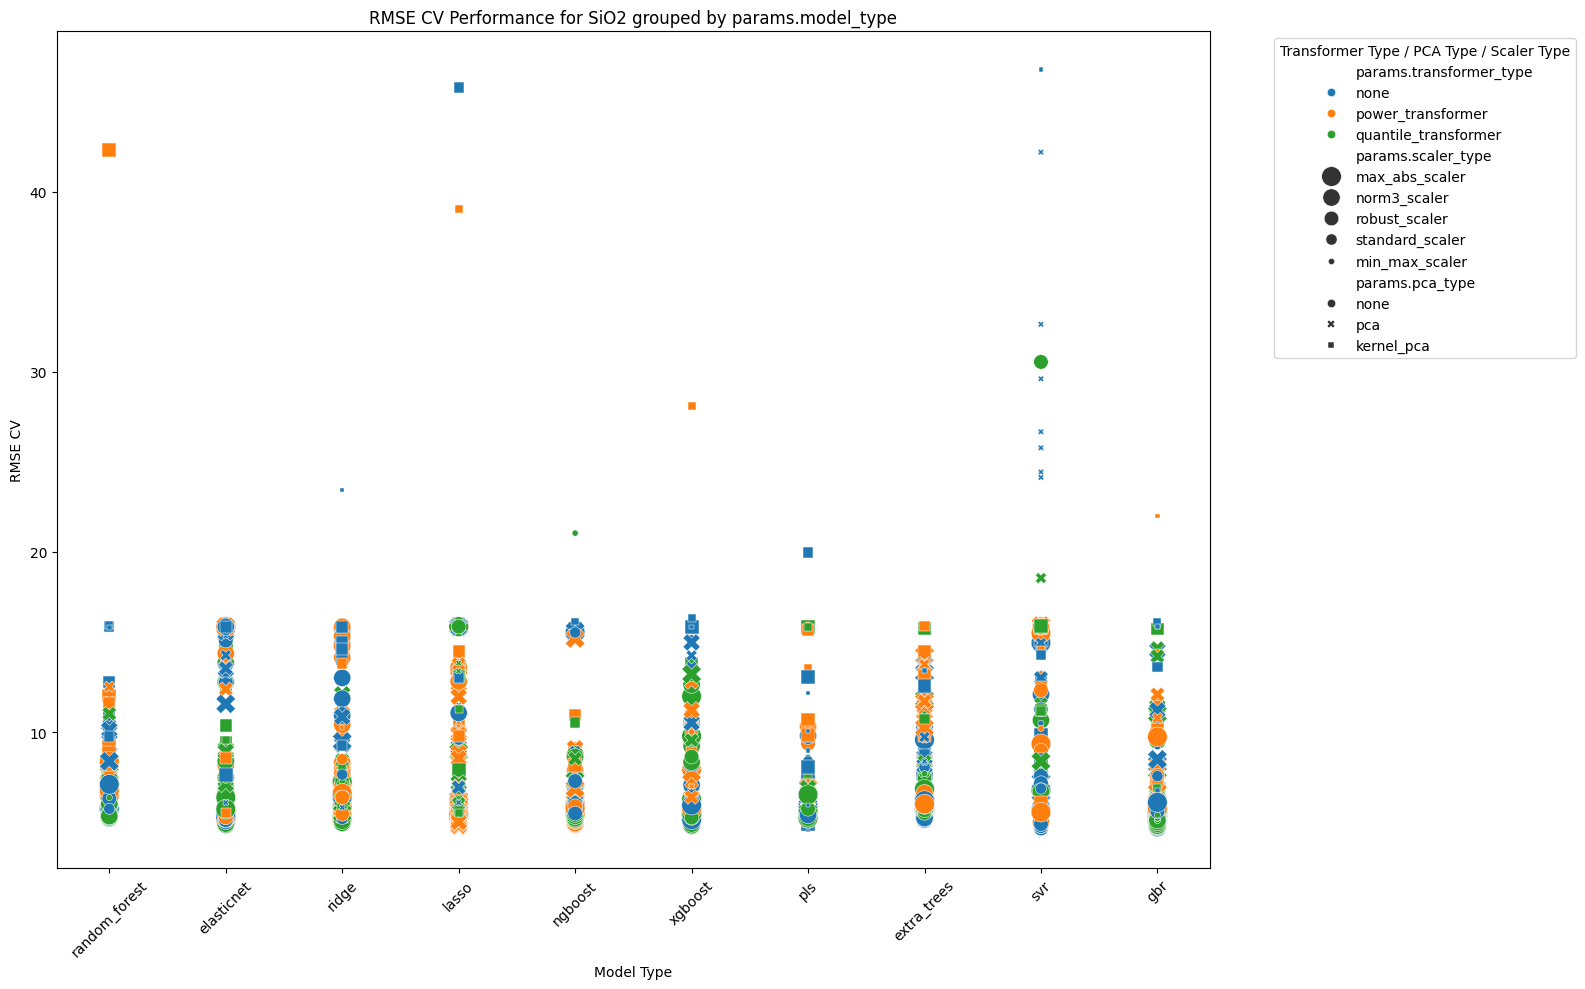

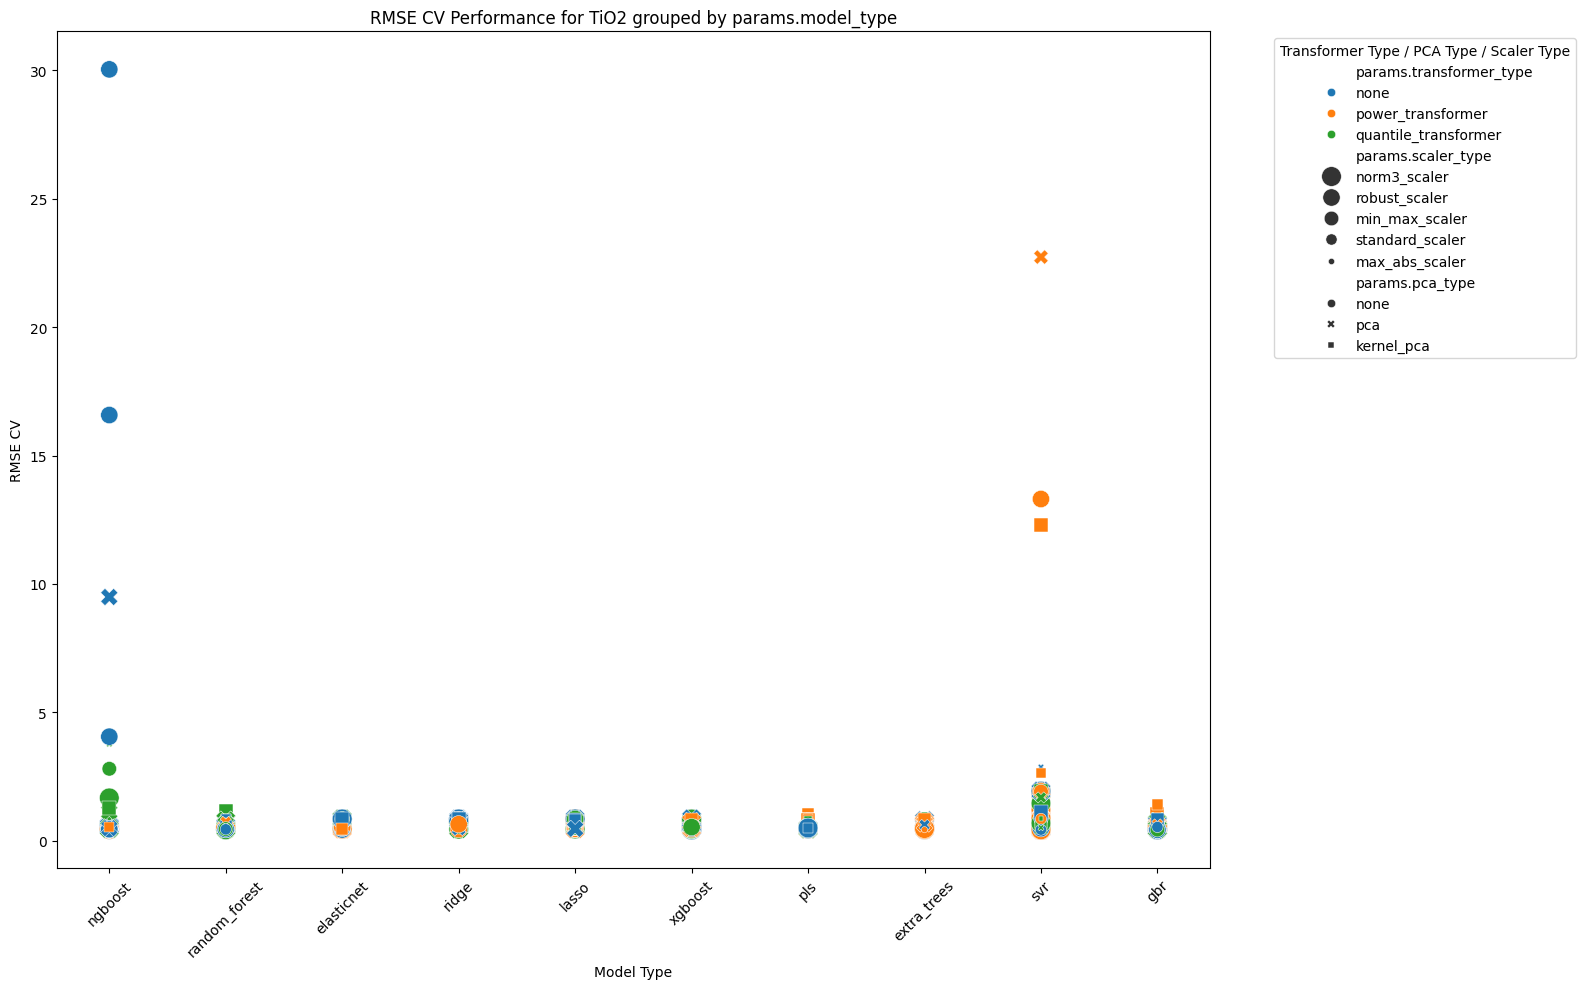

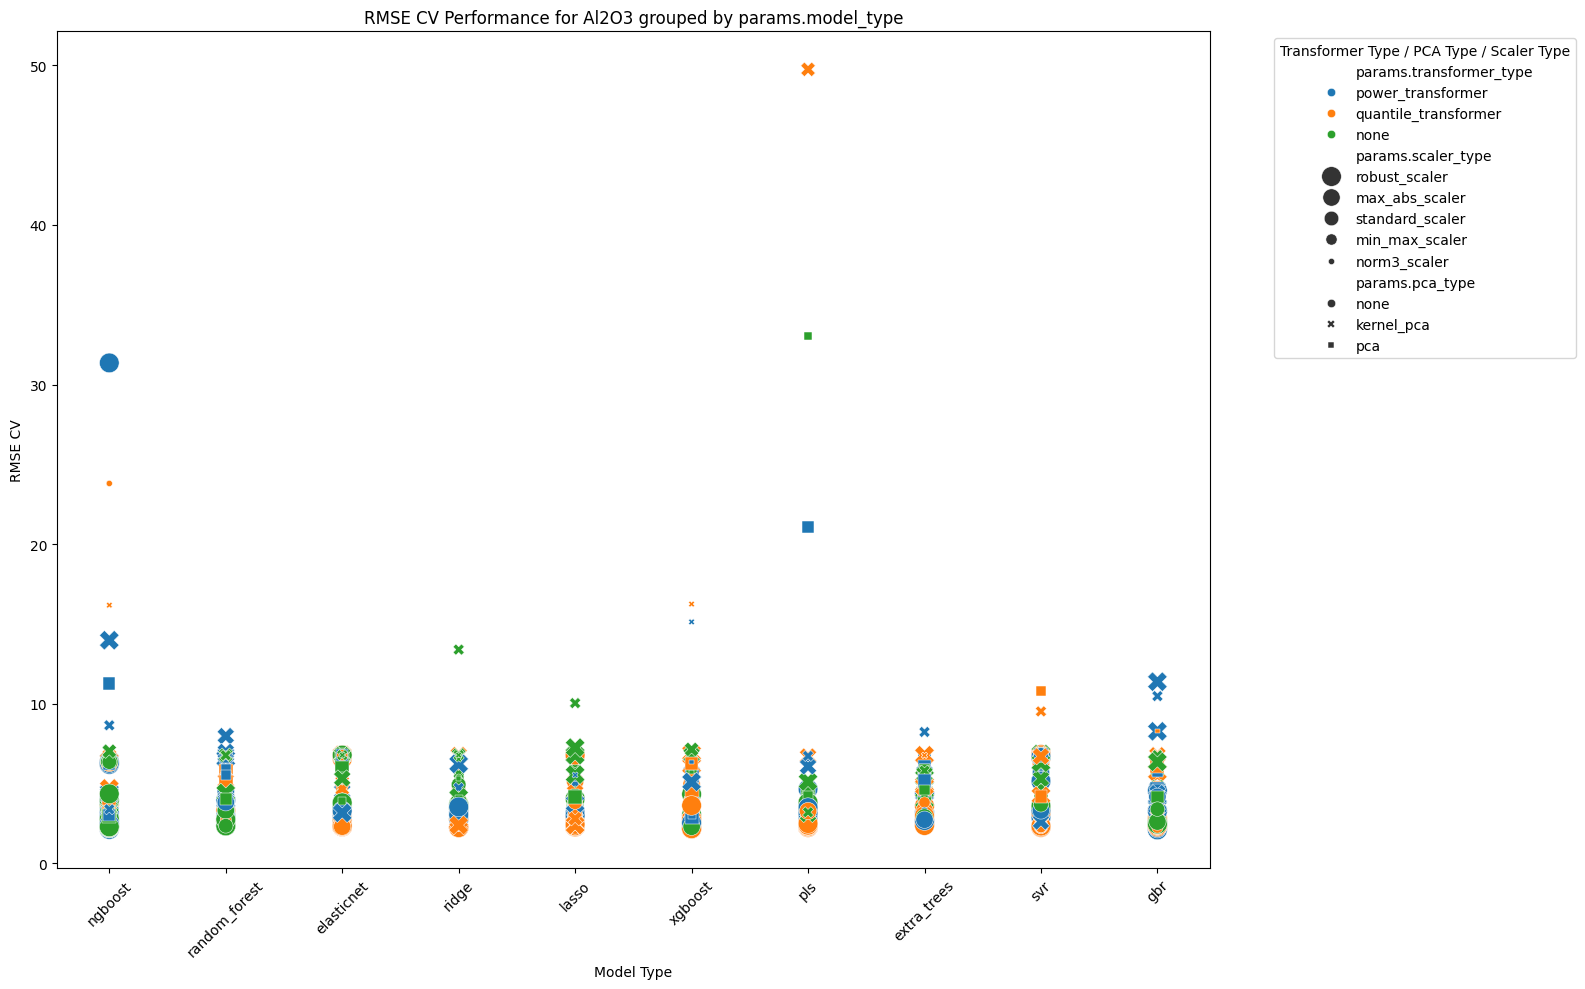

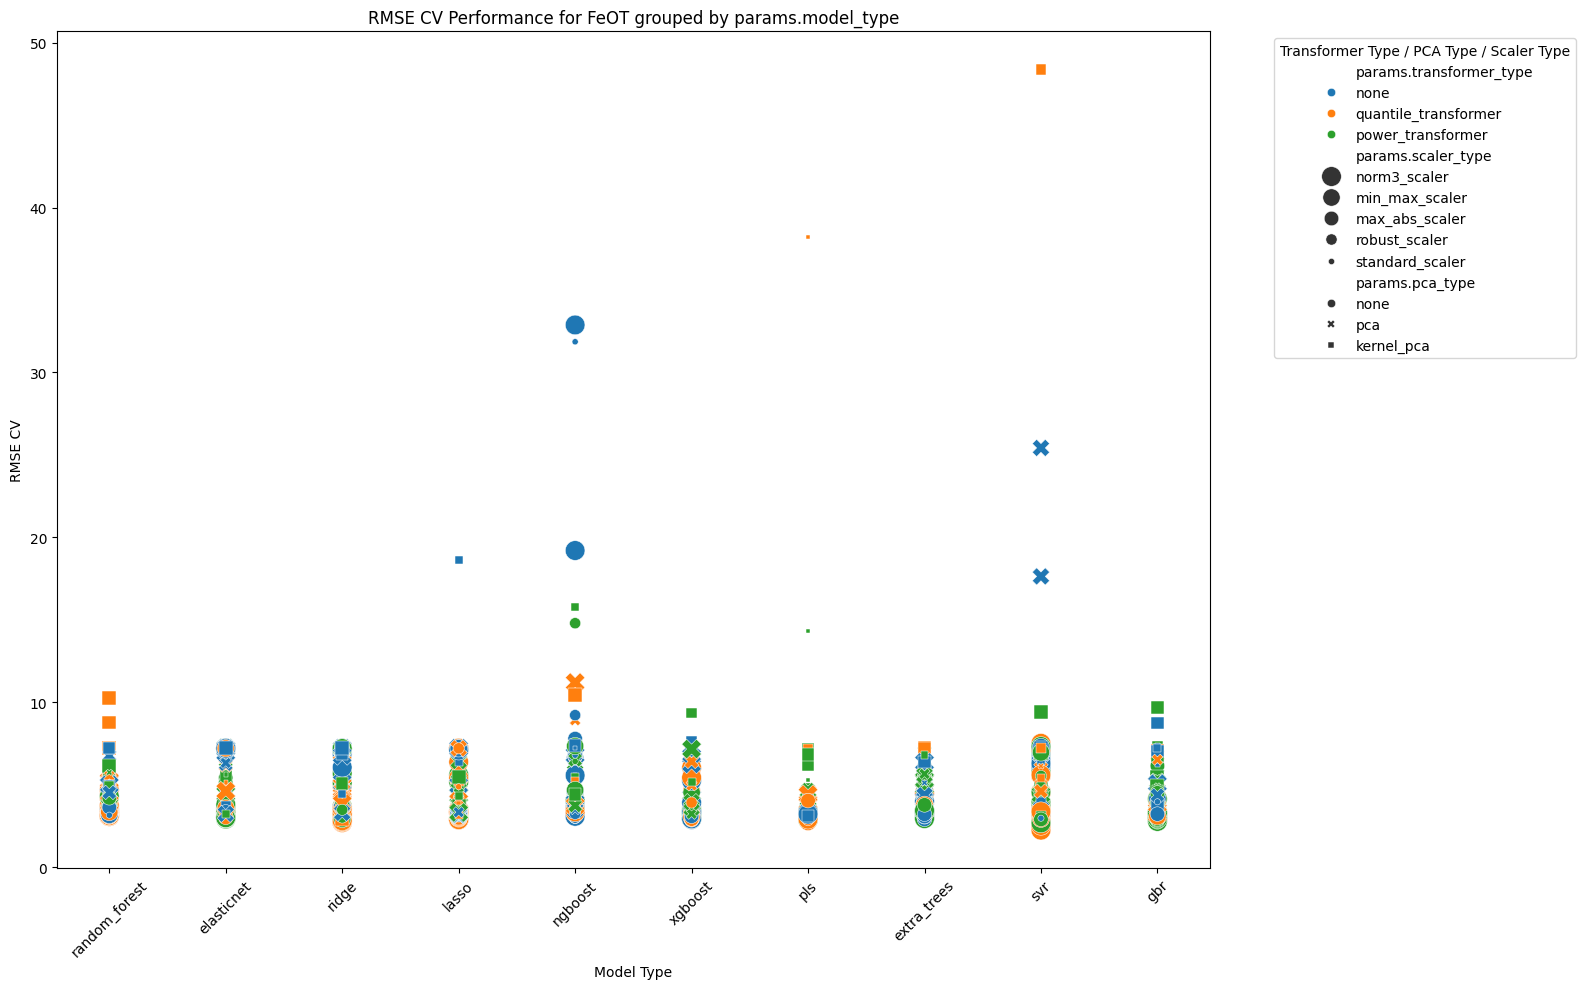

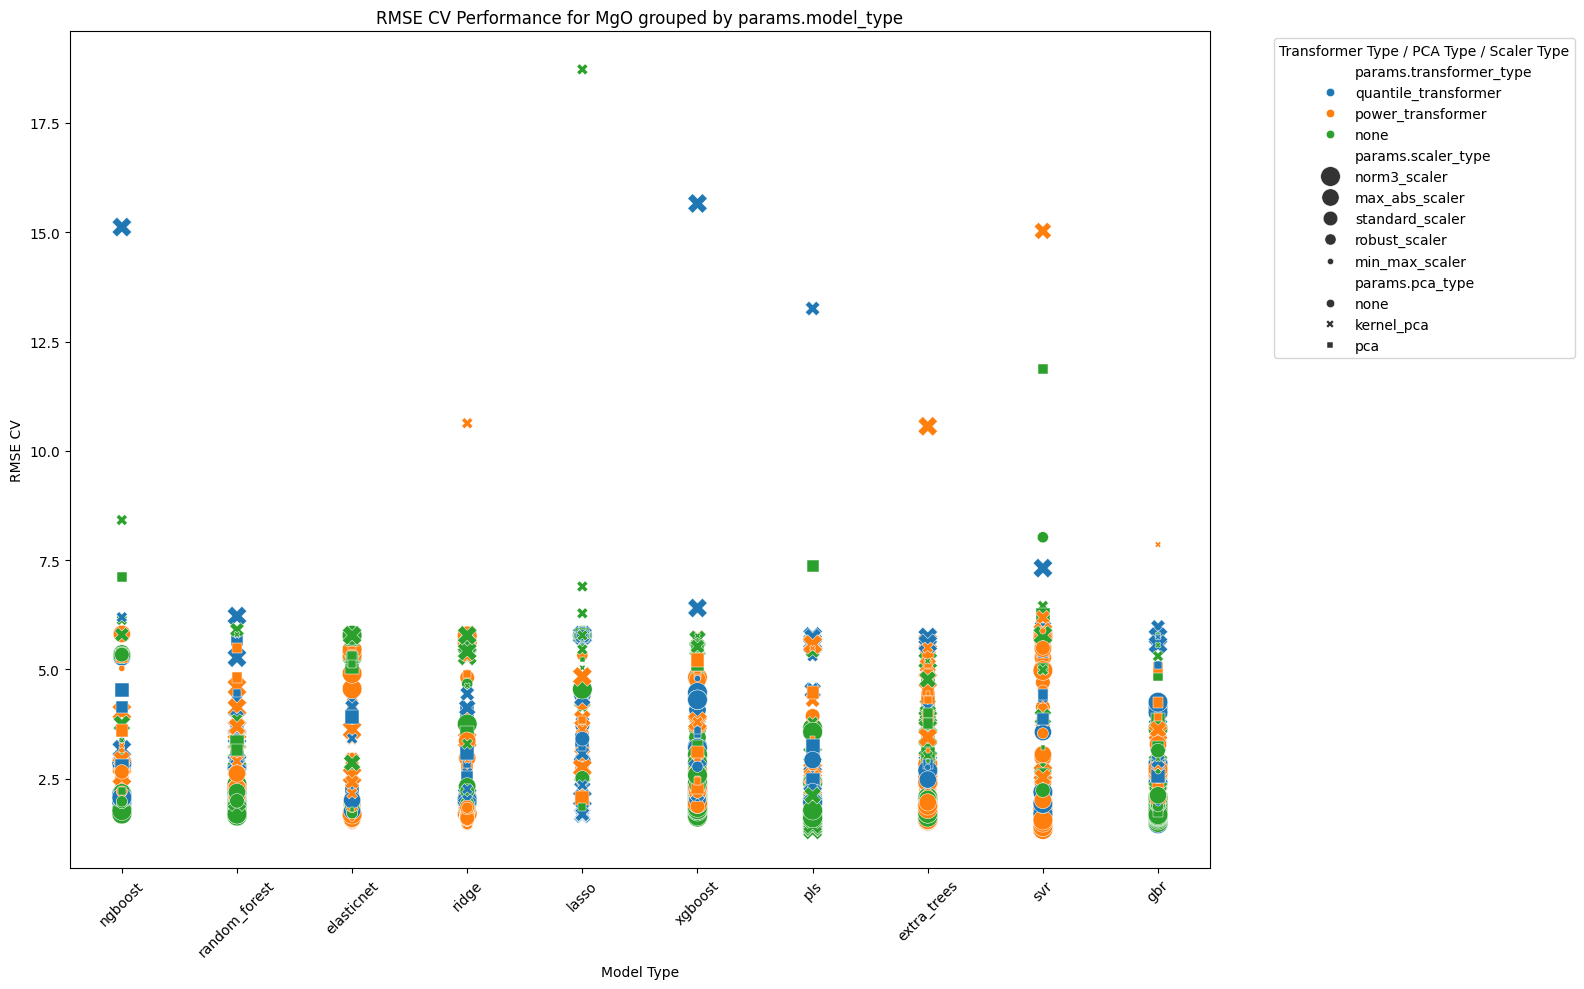

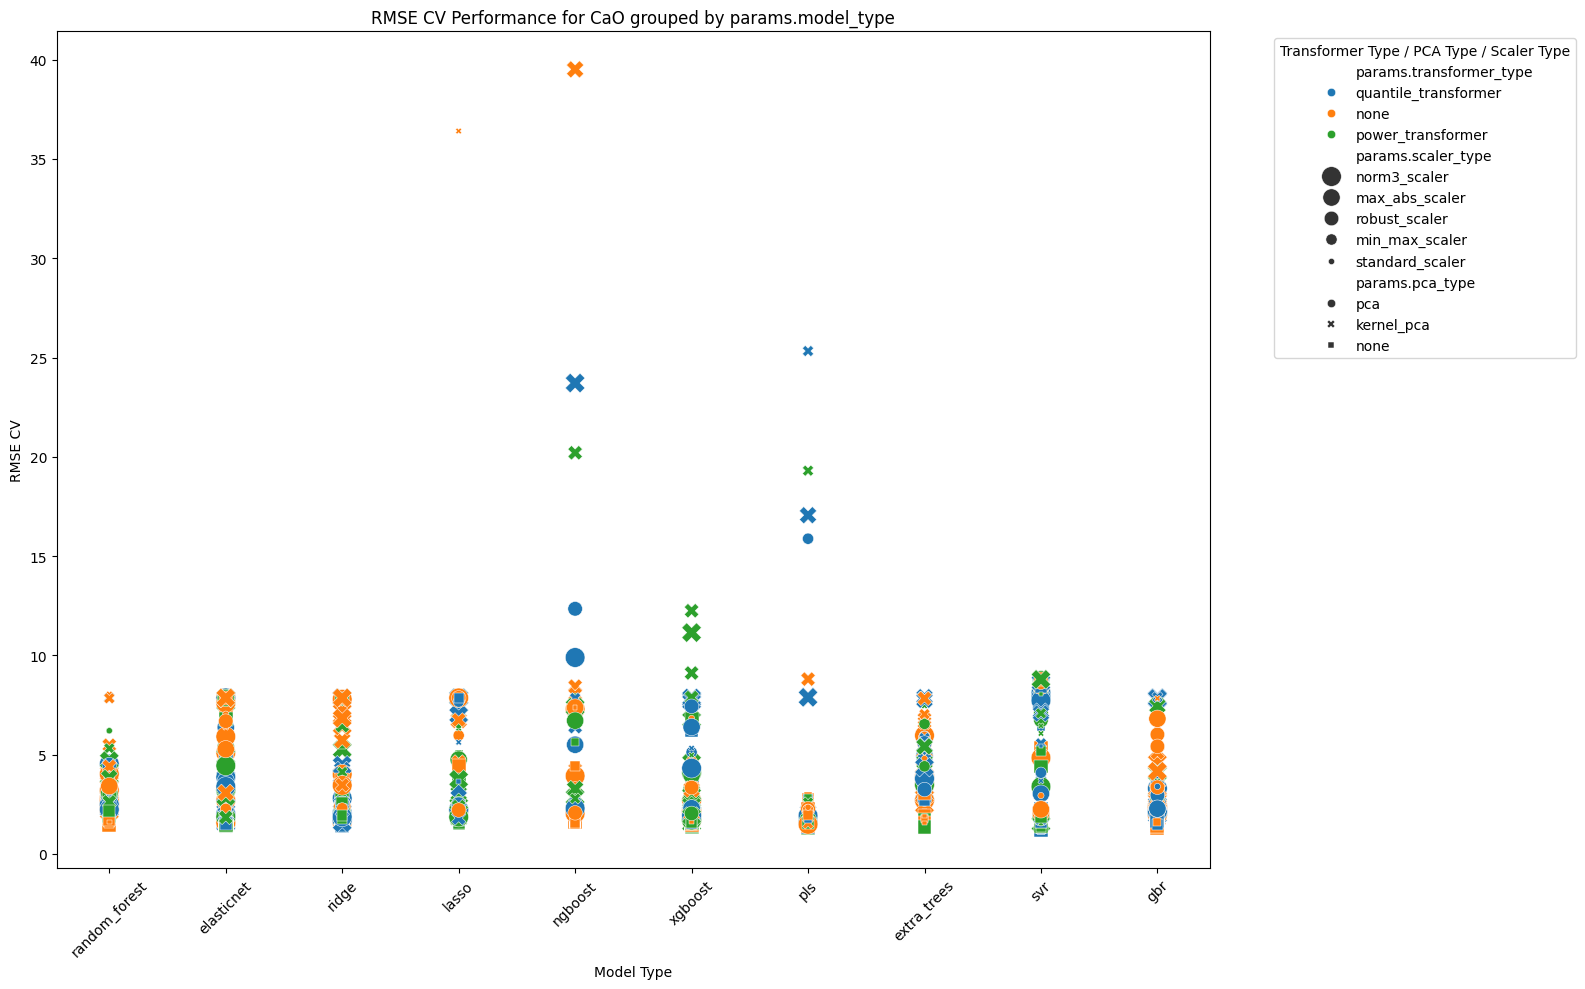

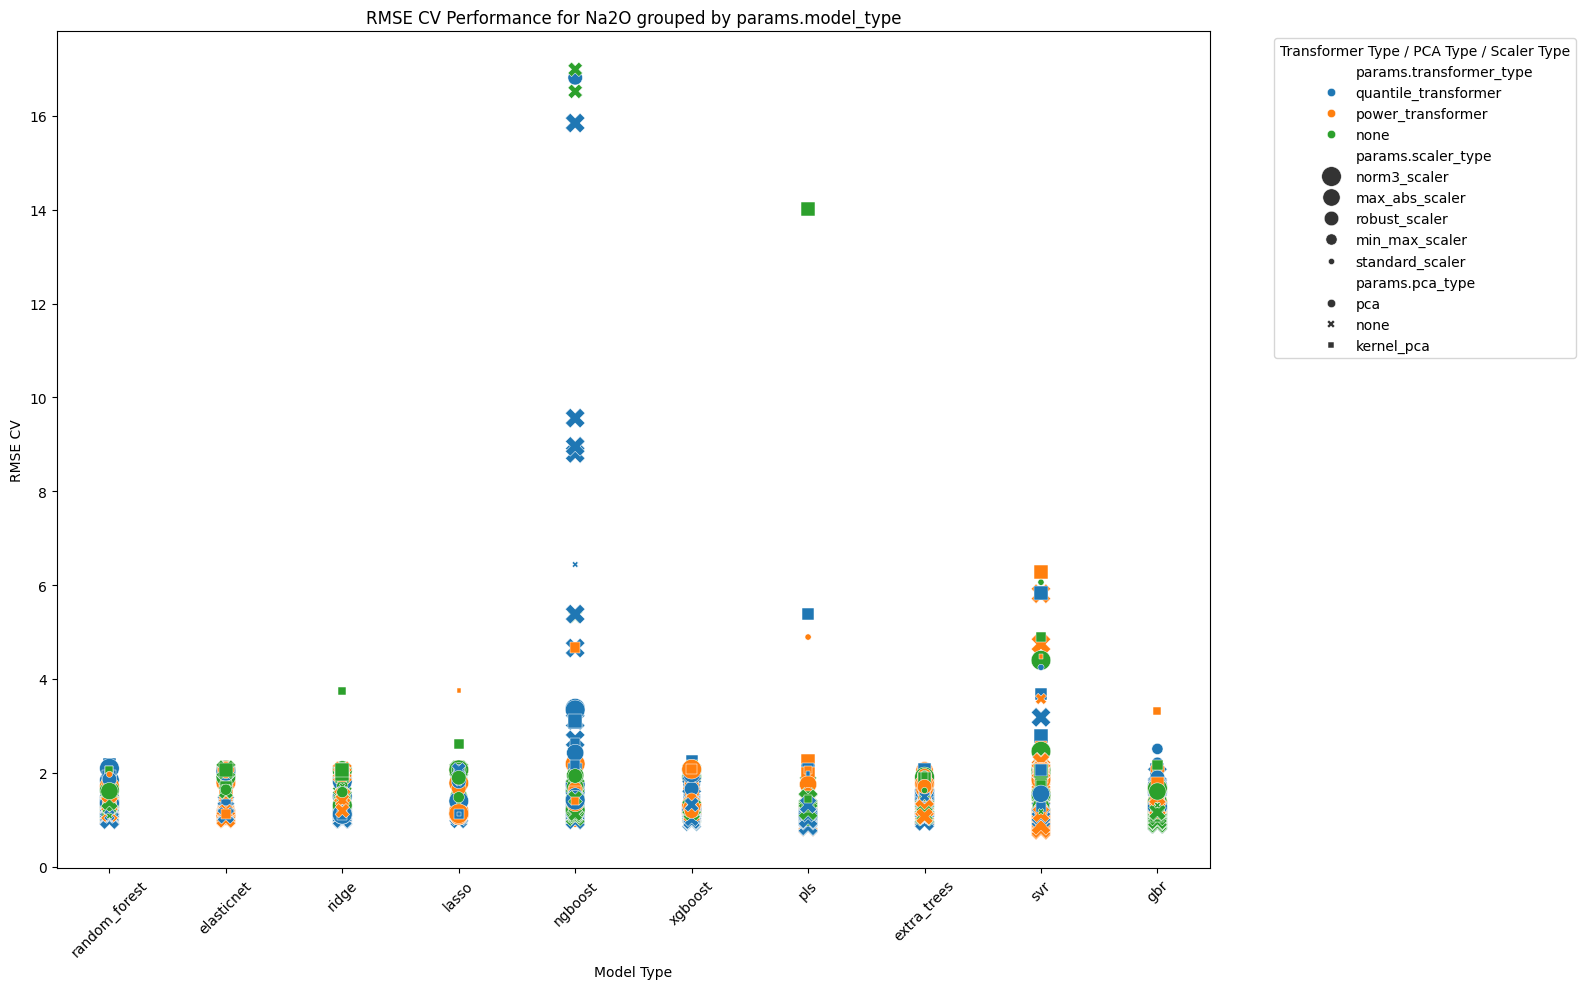

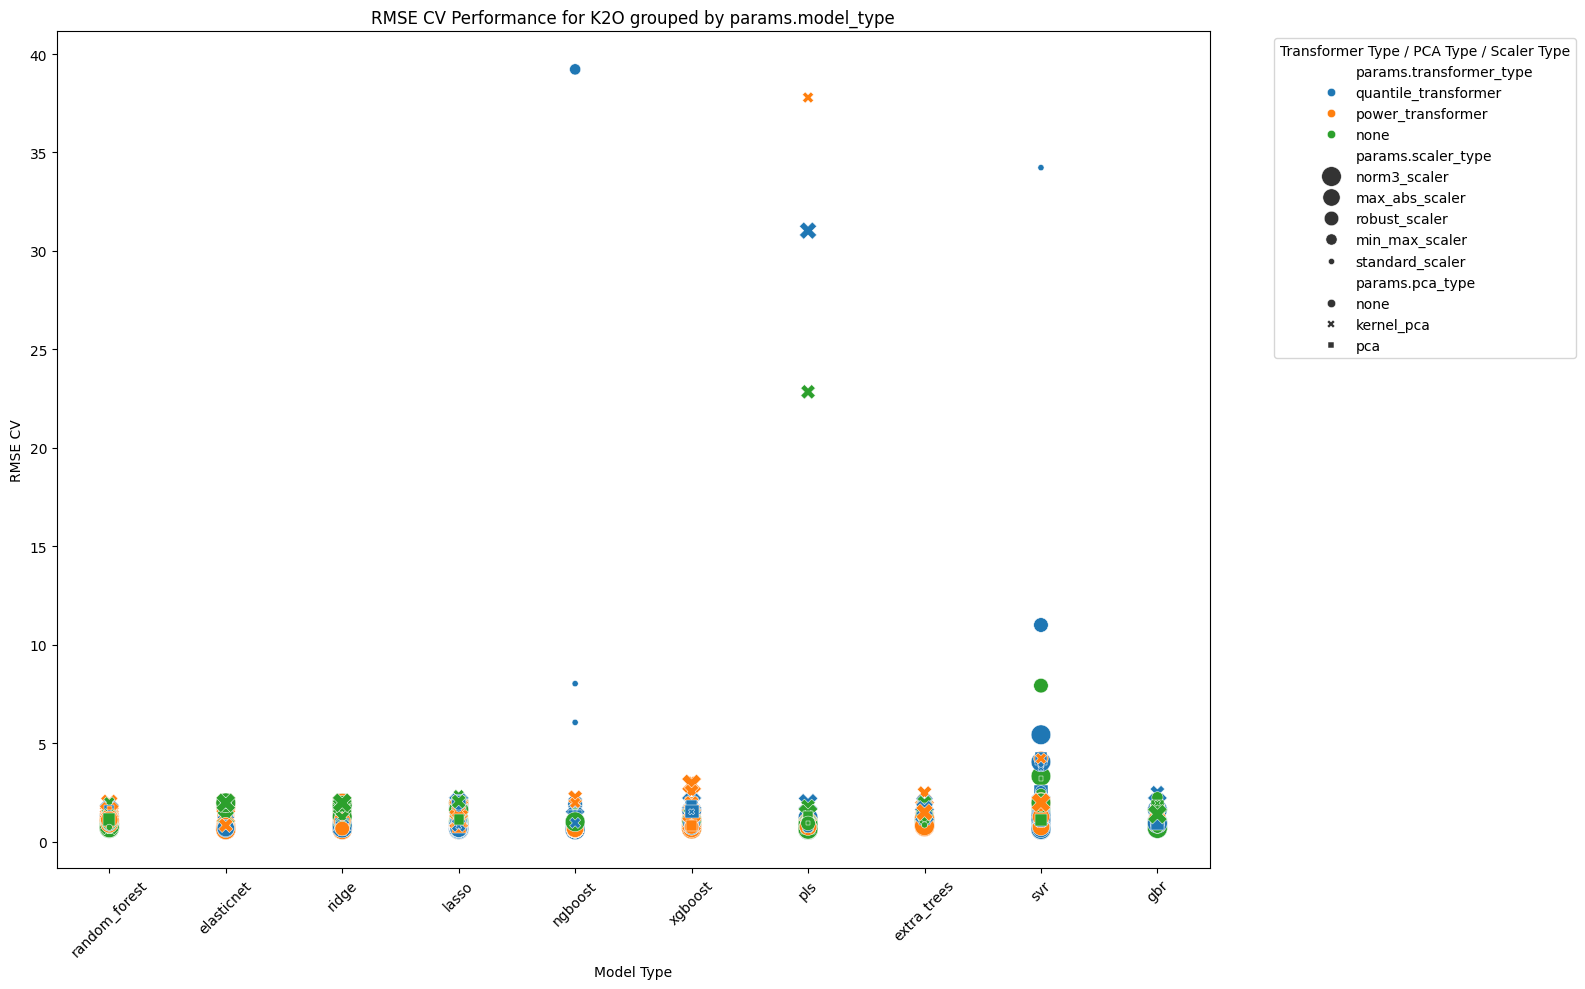

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the necessary columns are present
required_columns = ['params.oxide', 'metrics.rmse_cv', 'params.model_type', 'params.transformer_type', 'params.pca_type', 'params.scaler_type']
for col in required_columns:
    if (col not in runs.columns):
        raise ValueError(f"Missing required column: {col}")

# Filter out trials with rmse_cv > 50
runs_filtered = runs[runs['metrics.rmse_cv'] <= 50]

# Function to create visualizations based on a specified column
def create_visualizations(group_by_col):
    oxides = runs_filtered['params.oxide'].unique()
    for oxide in oxides:
        oxide_data = runs_filtered[runs_filtered['params.oxide'] == oxide]
        
        plt.figure(figsize=(16, 10))
        sns.scatterplot(data=oxide_data, x=group_by_col, y='metrics.rmse_cv', hue='params.transformer_type', style='params.pca_type', size='params.scaler_type', sizes=(20, 200))
        plt.title(f'RMSE CV Performance for {oxide} grouped by {group_by_col}')
        plt.xlabel(group_by_col.replace('params.', '').replace('_', ' ').title())
        plt.ylabel('RMSE CV')
        plt.legend(title='Transformer Type / PCA Type / Scaler Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage: create visualizations grouped by 'params.model_type'
create_visualizations('params.model_type')


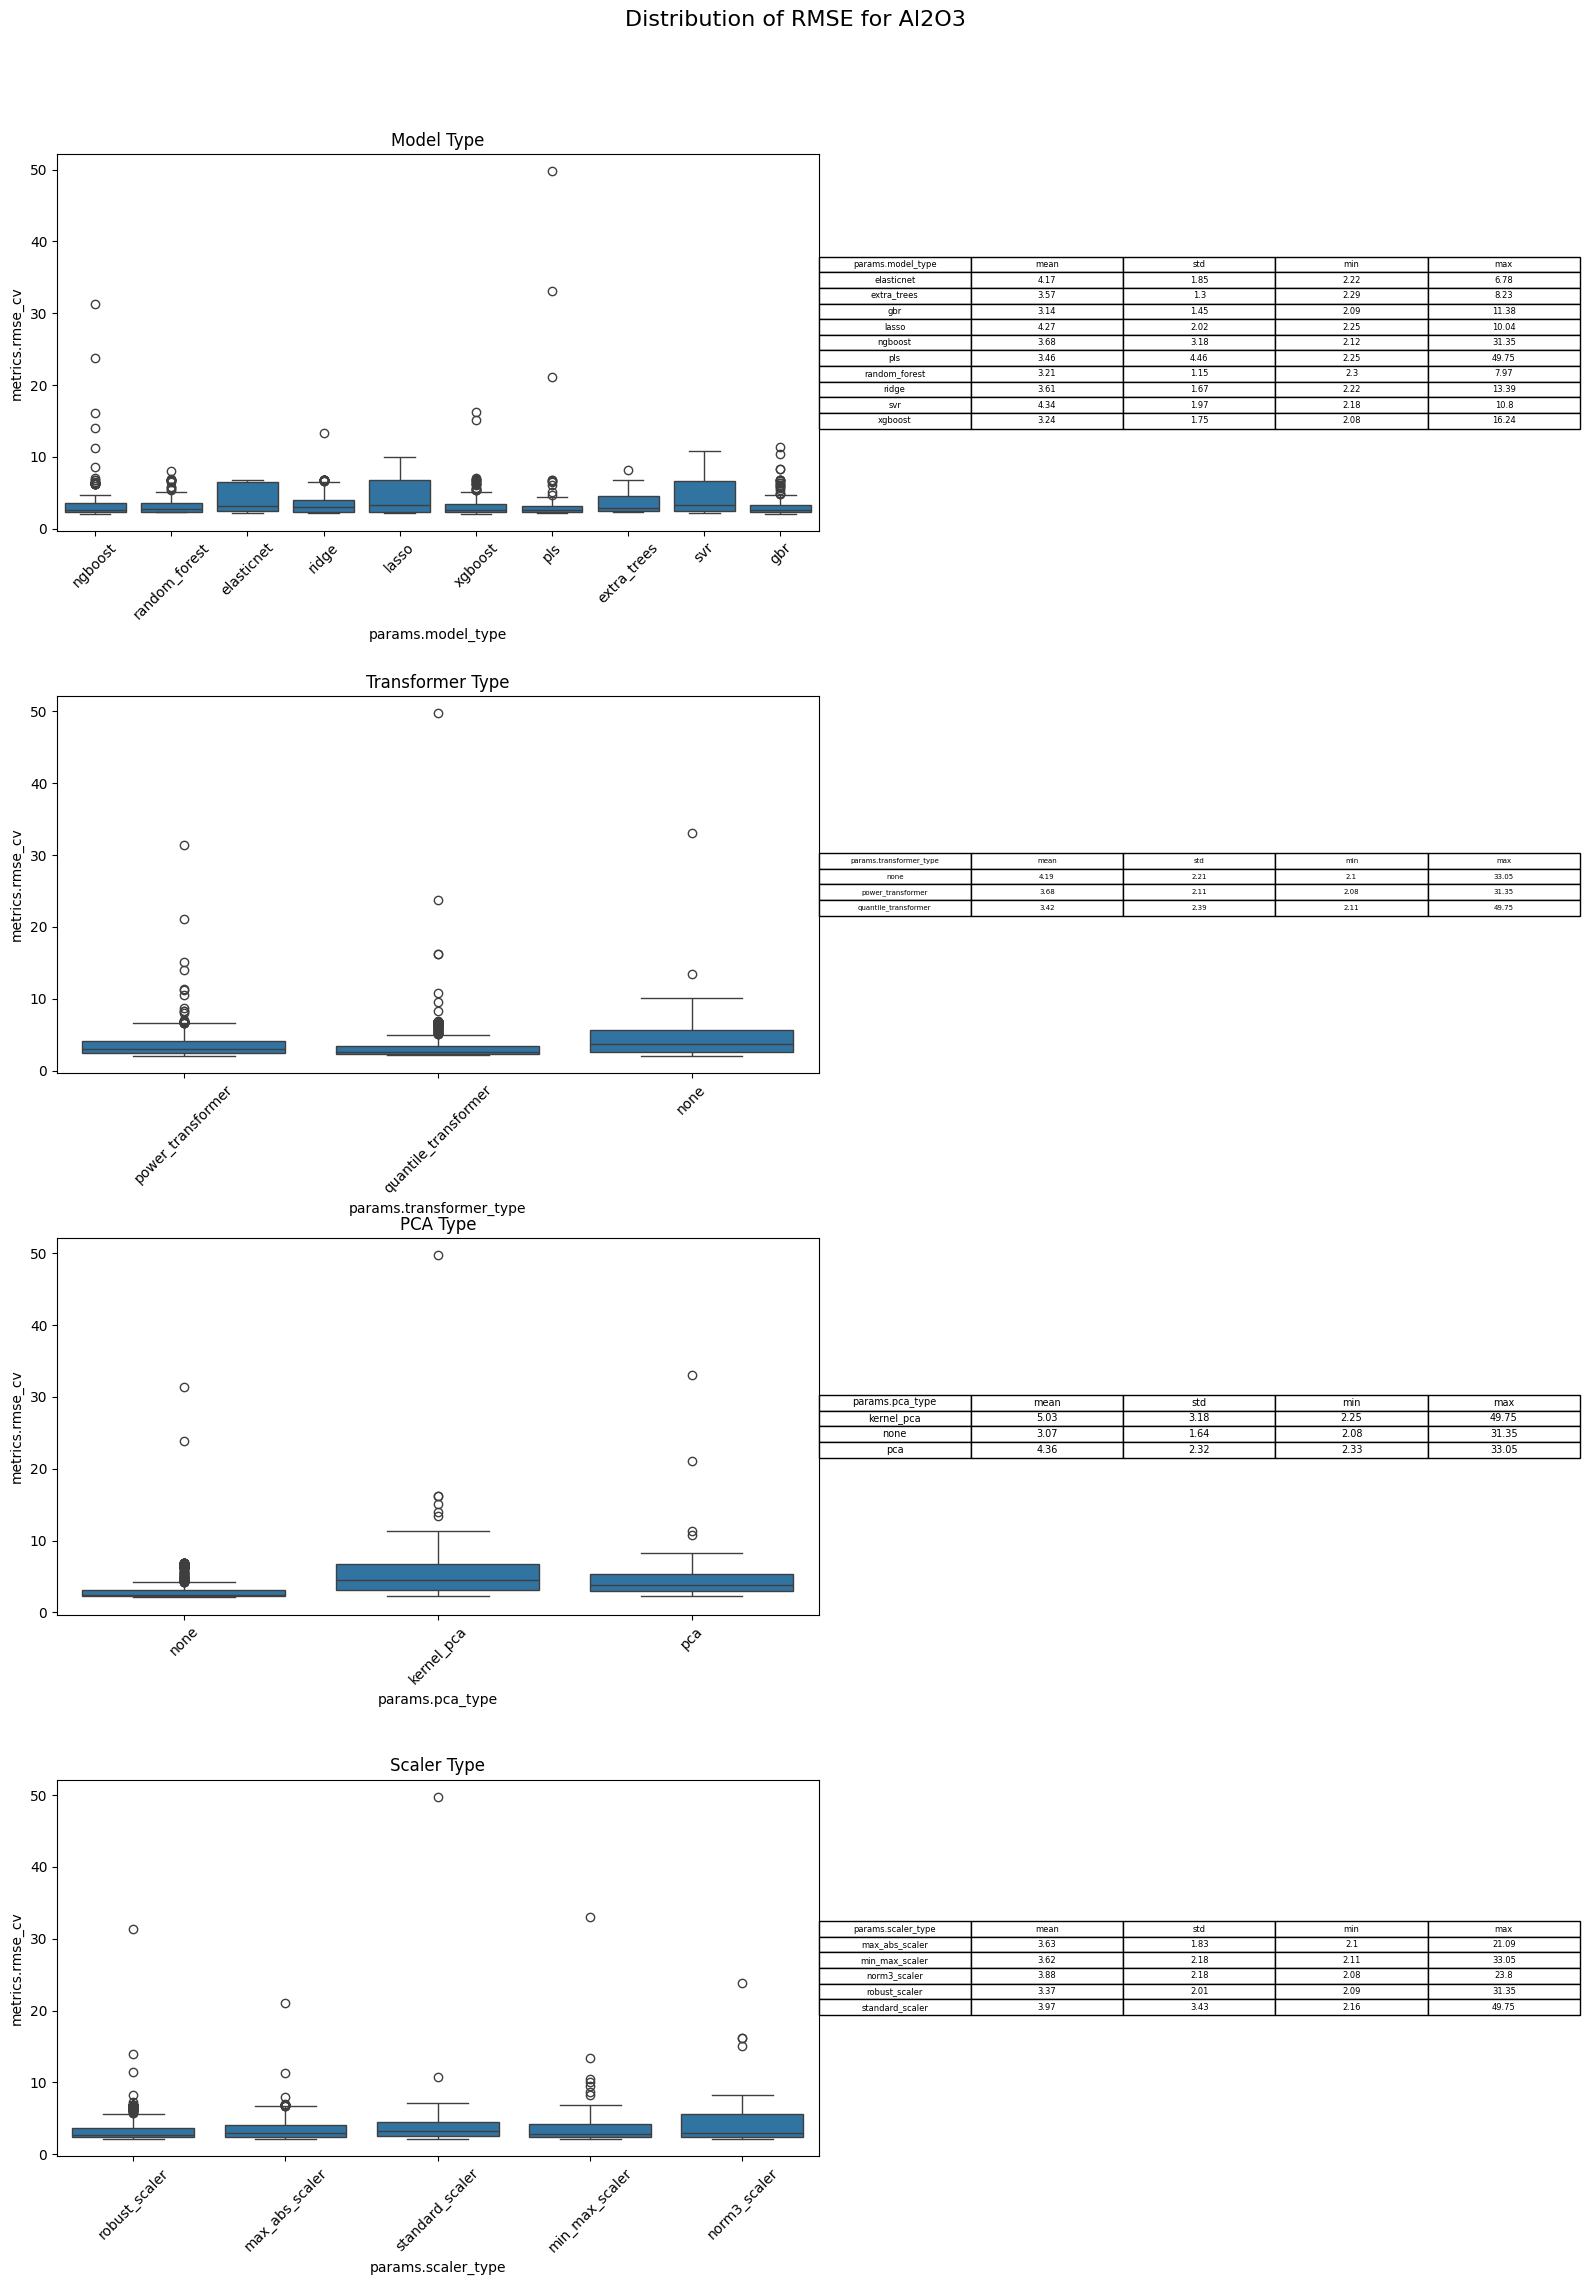

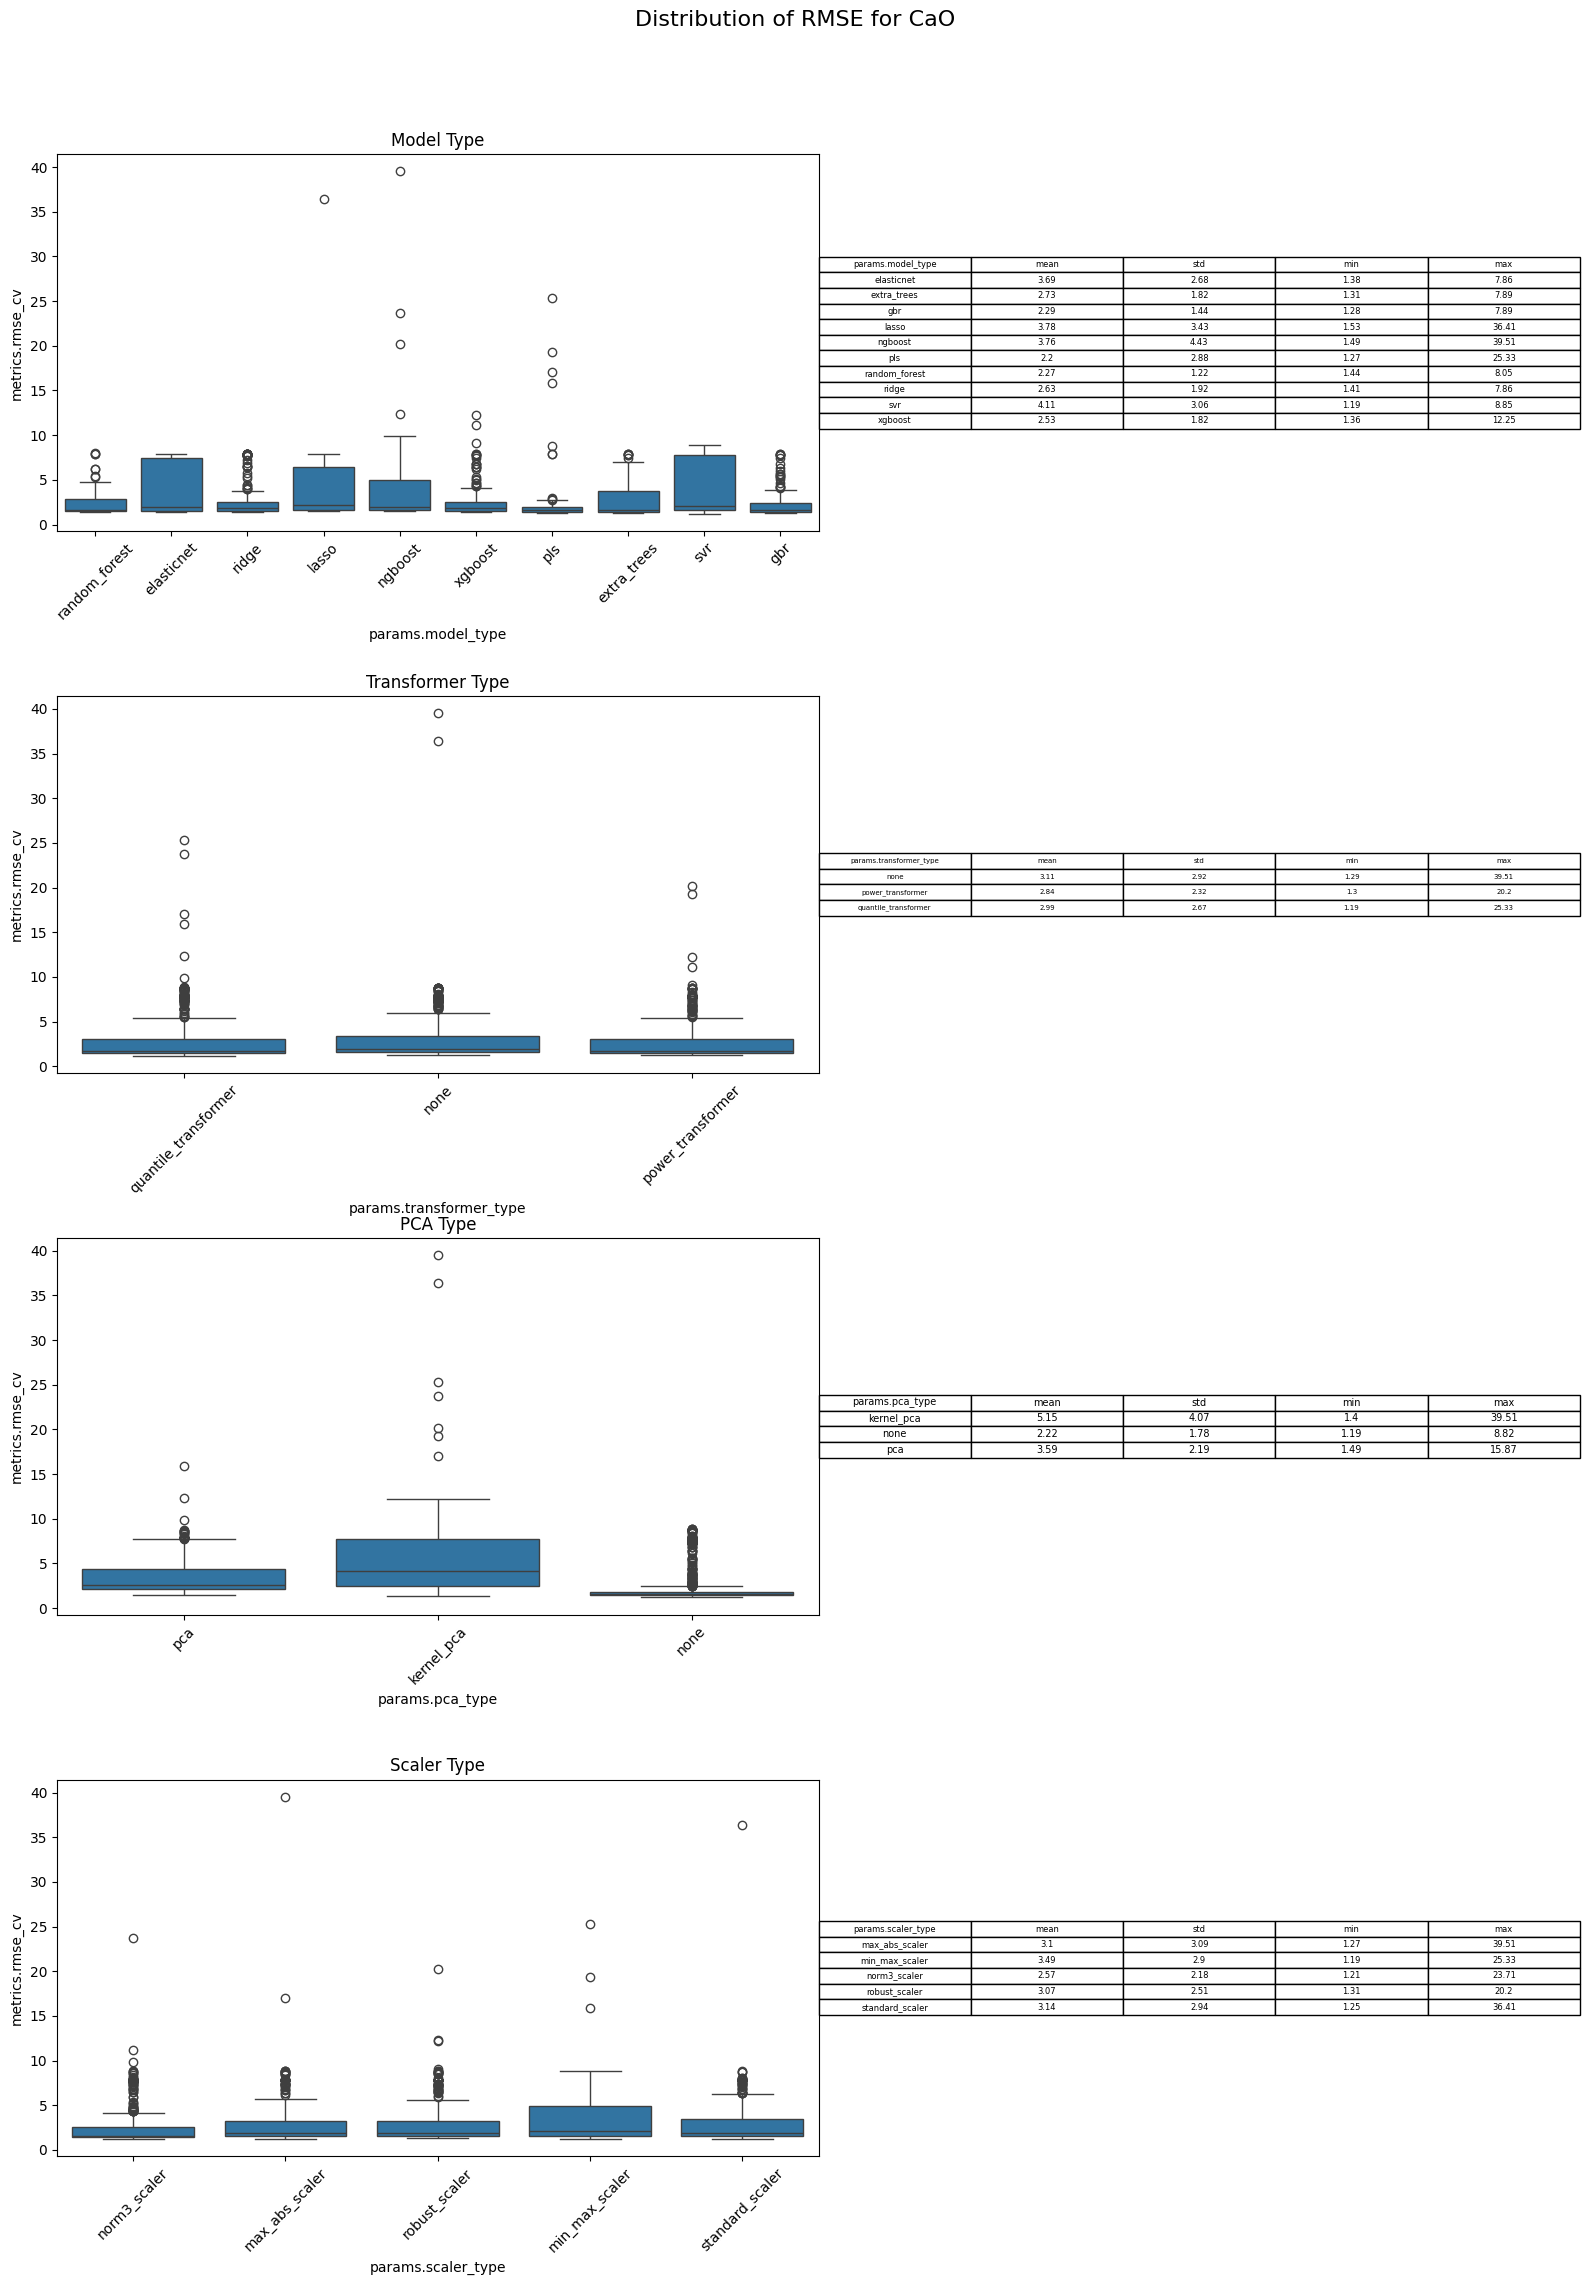

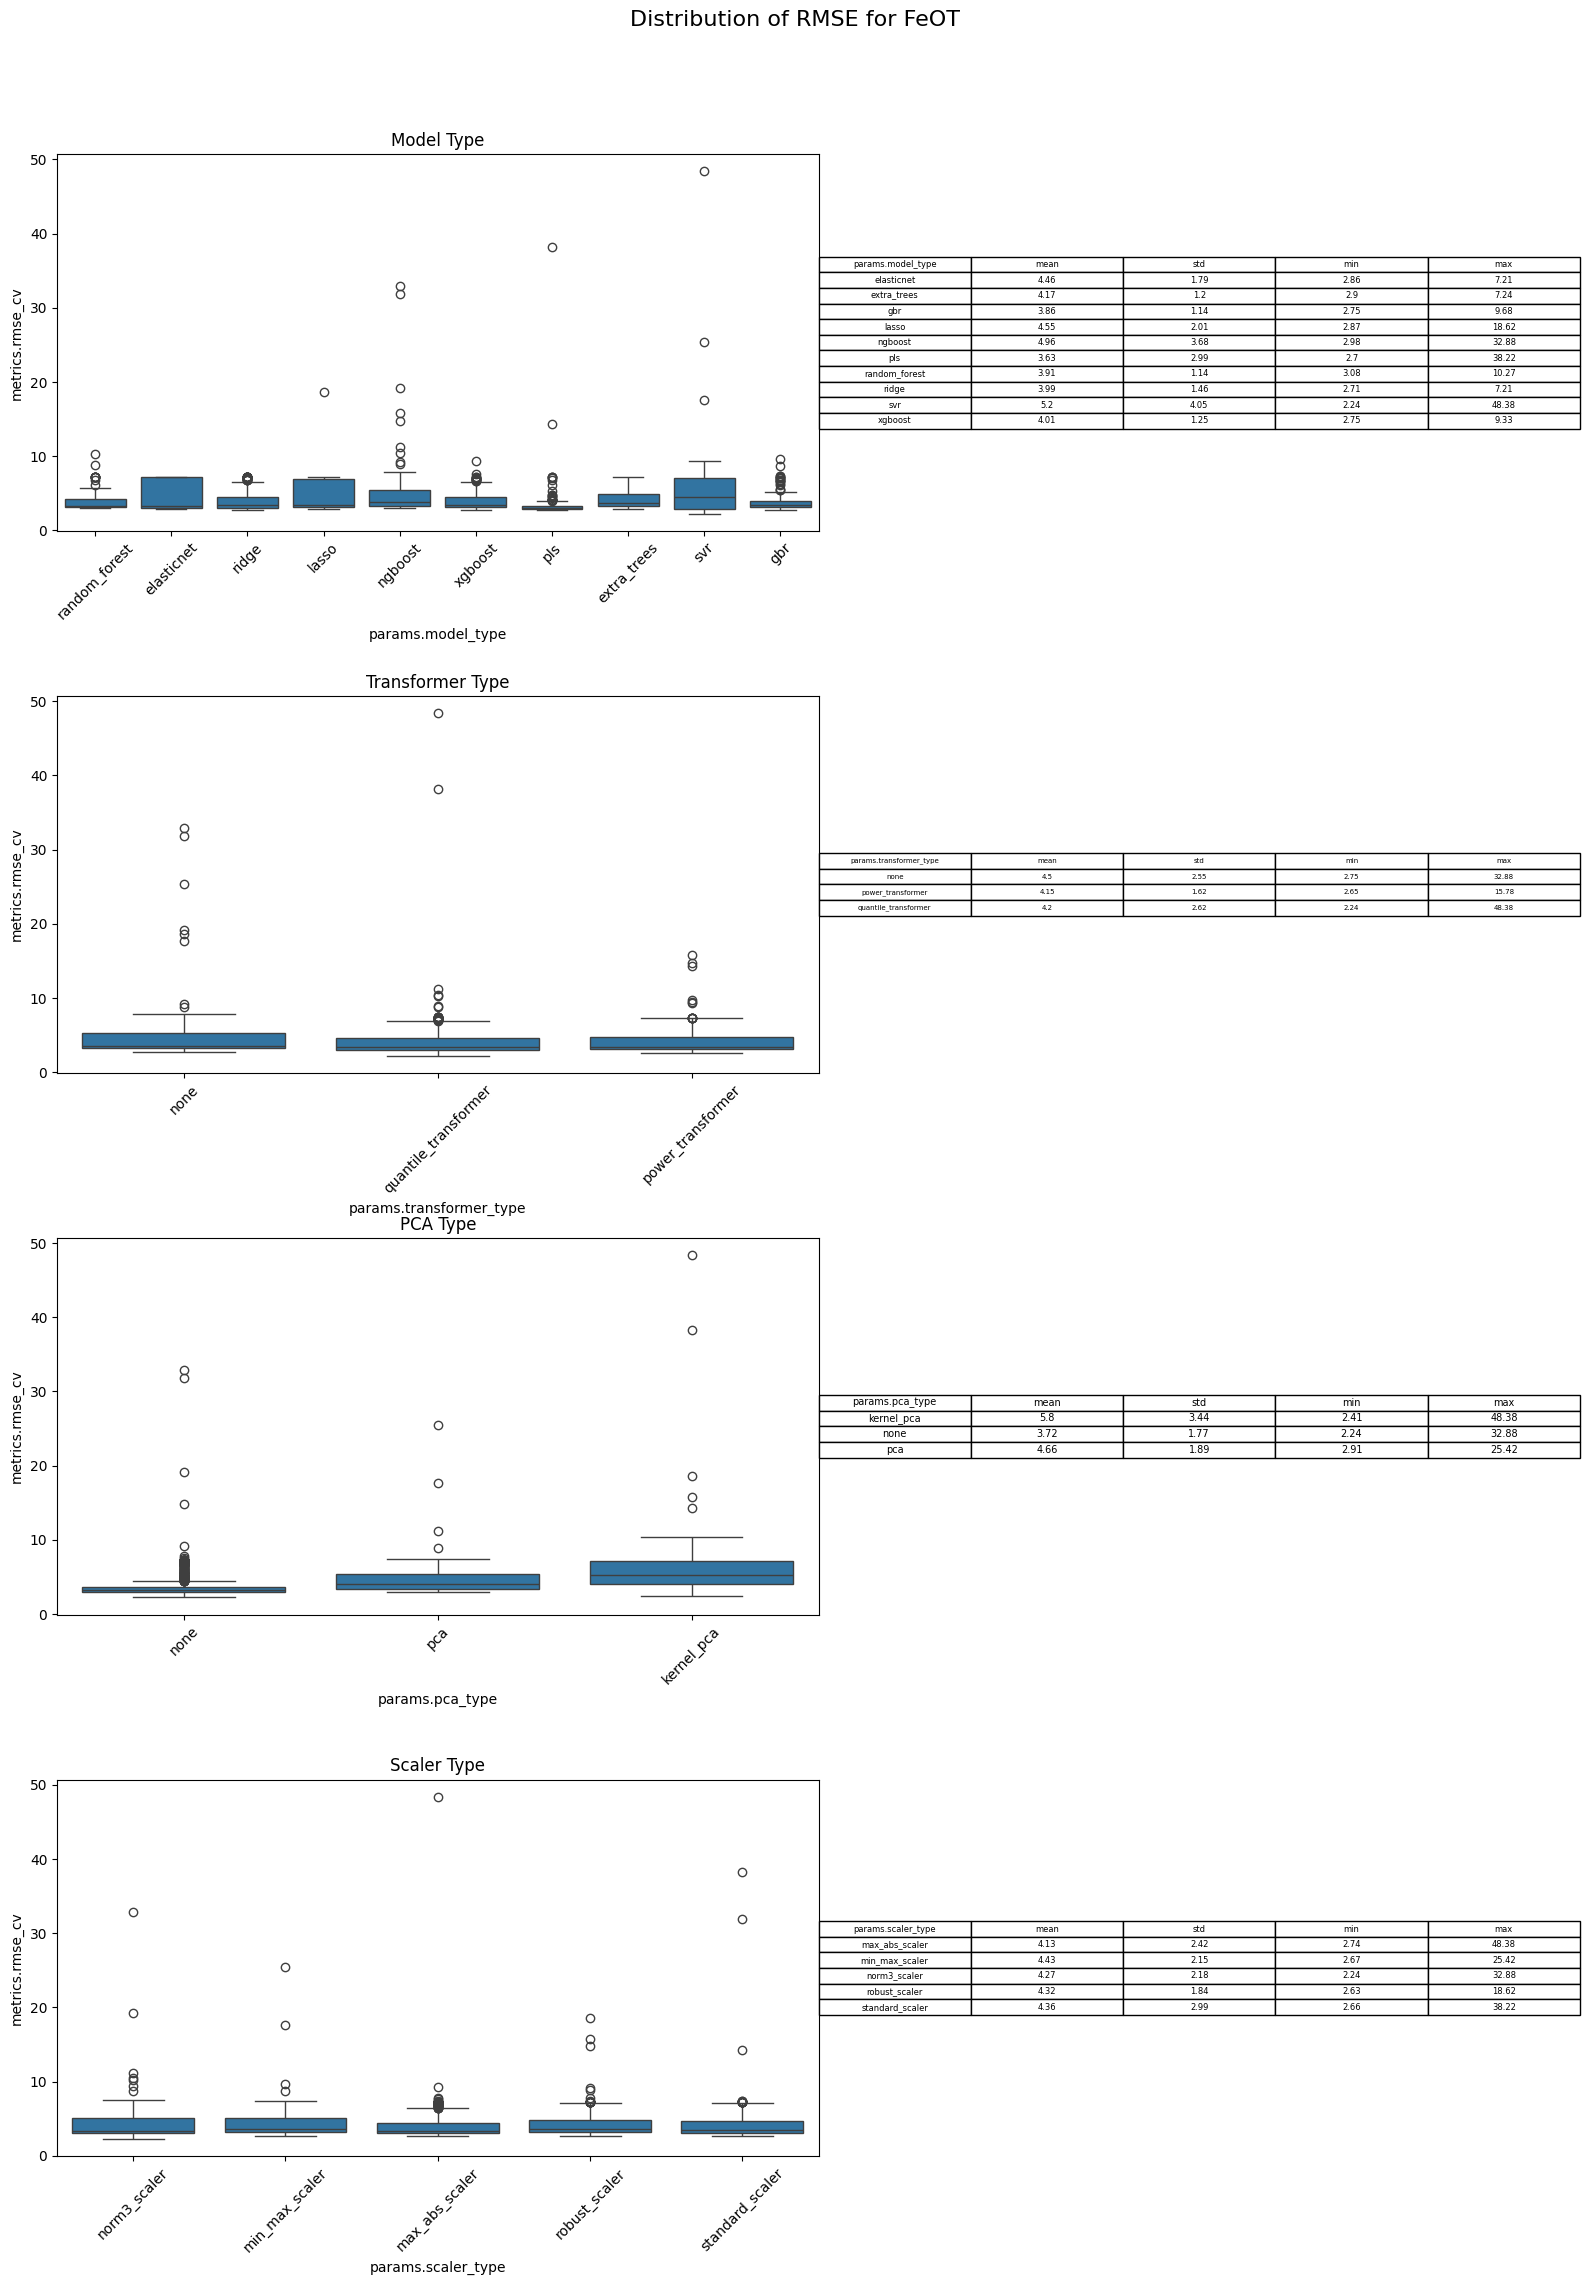

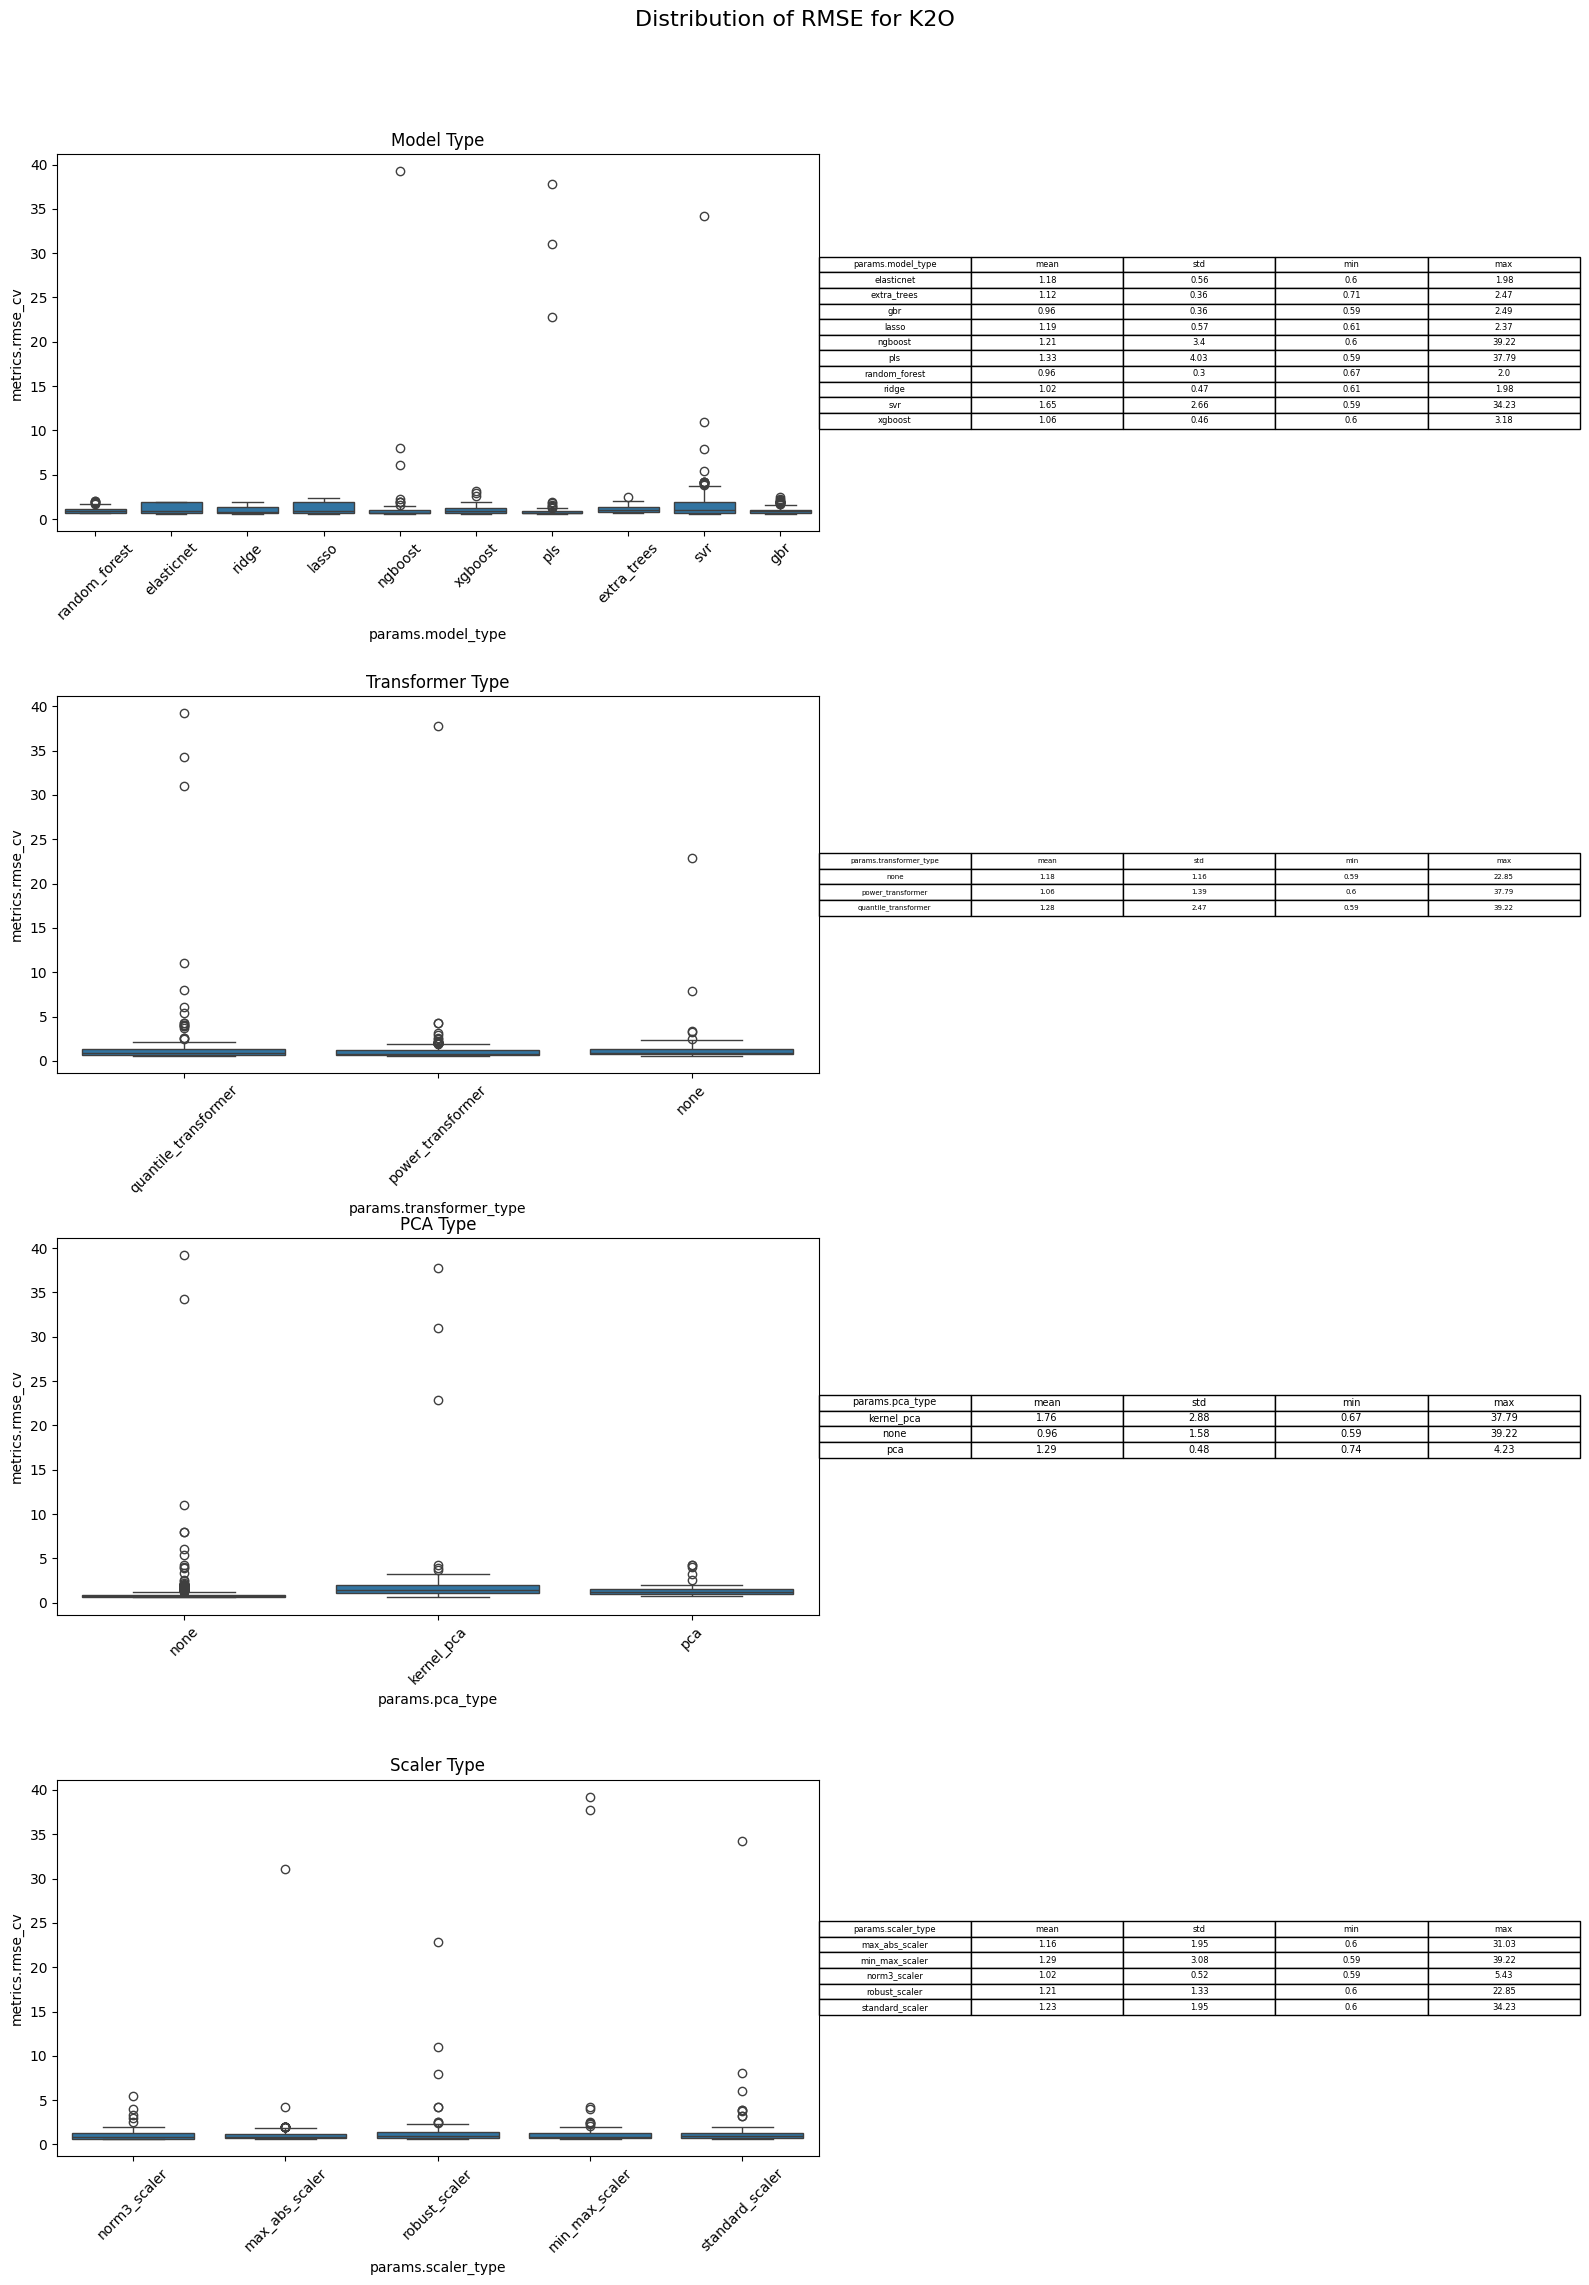

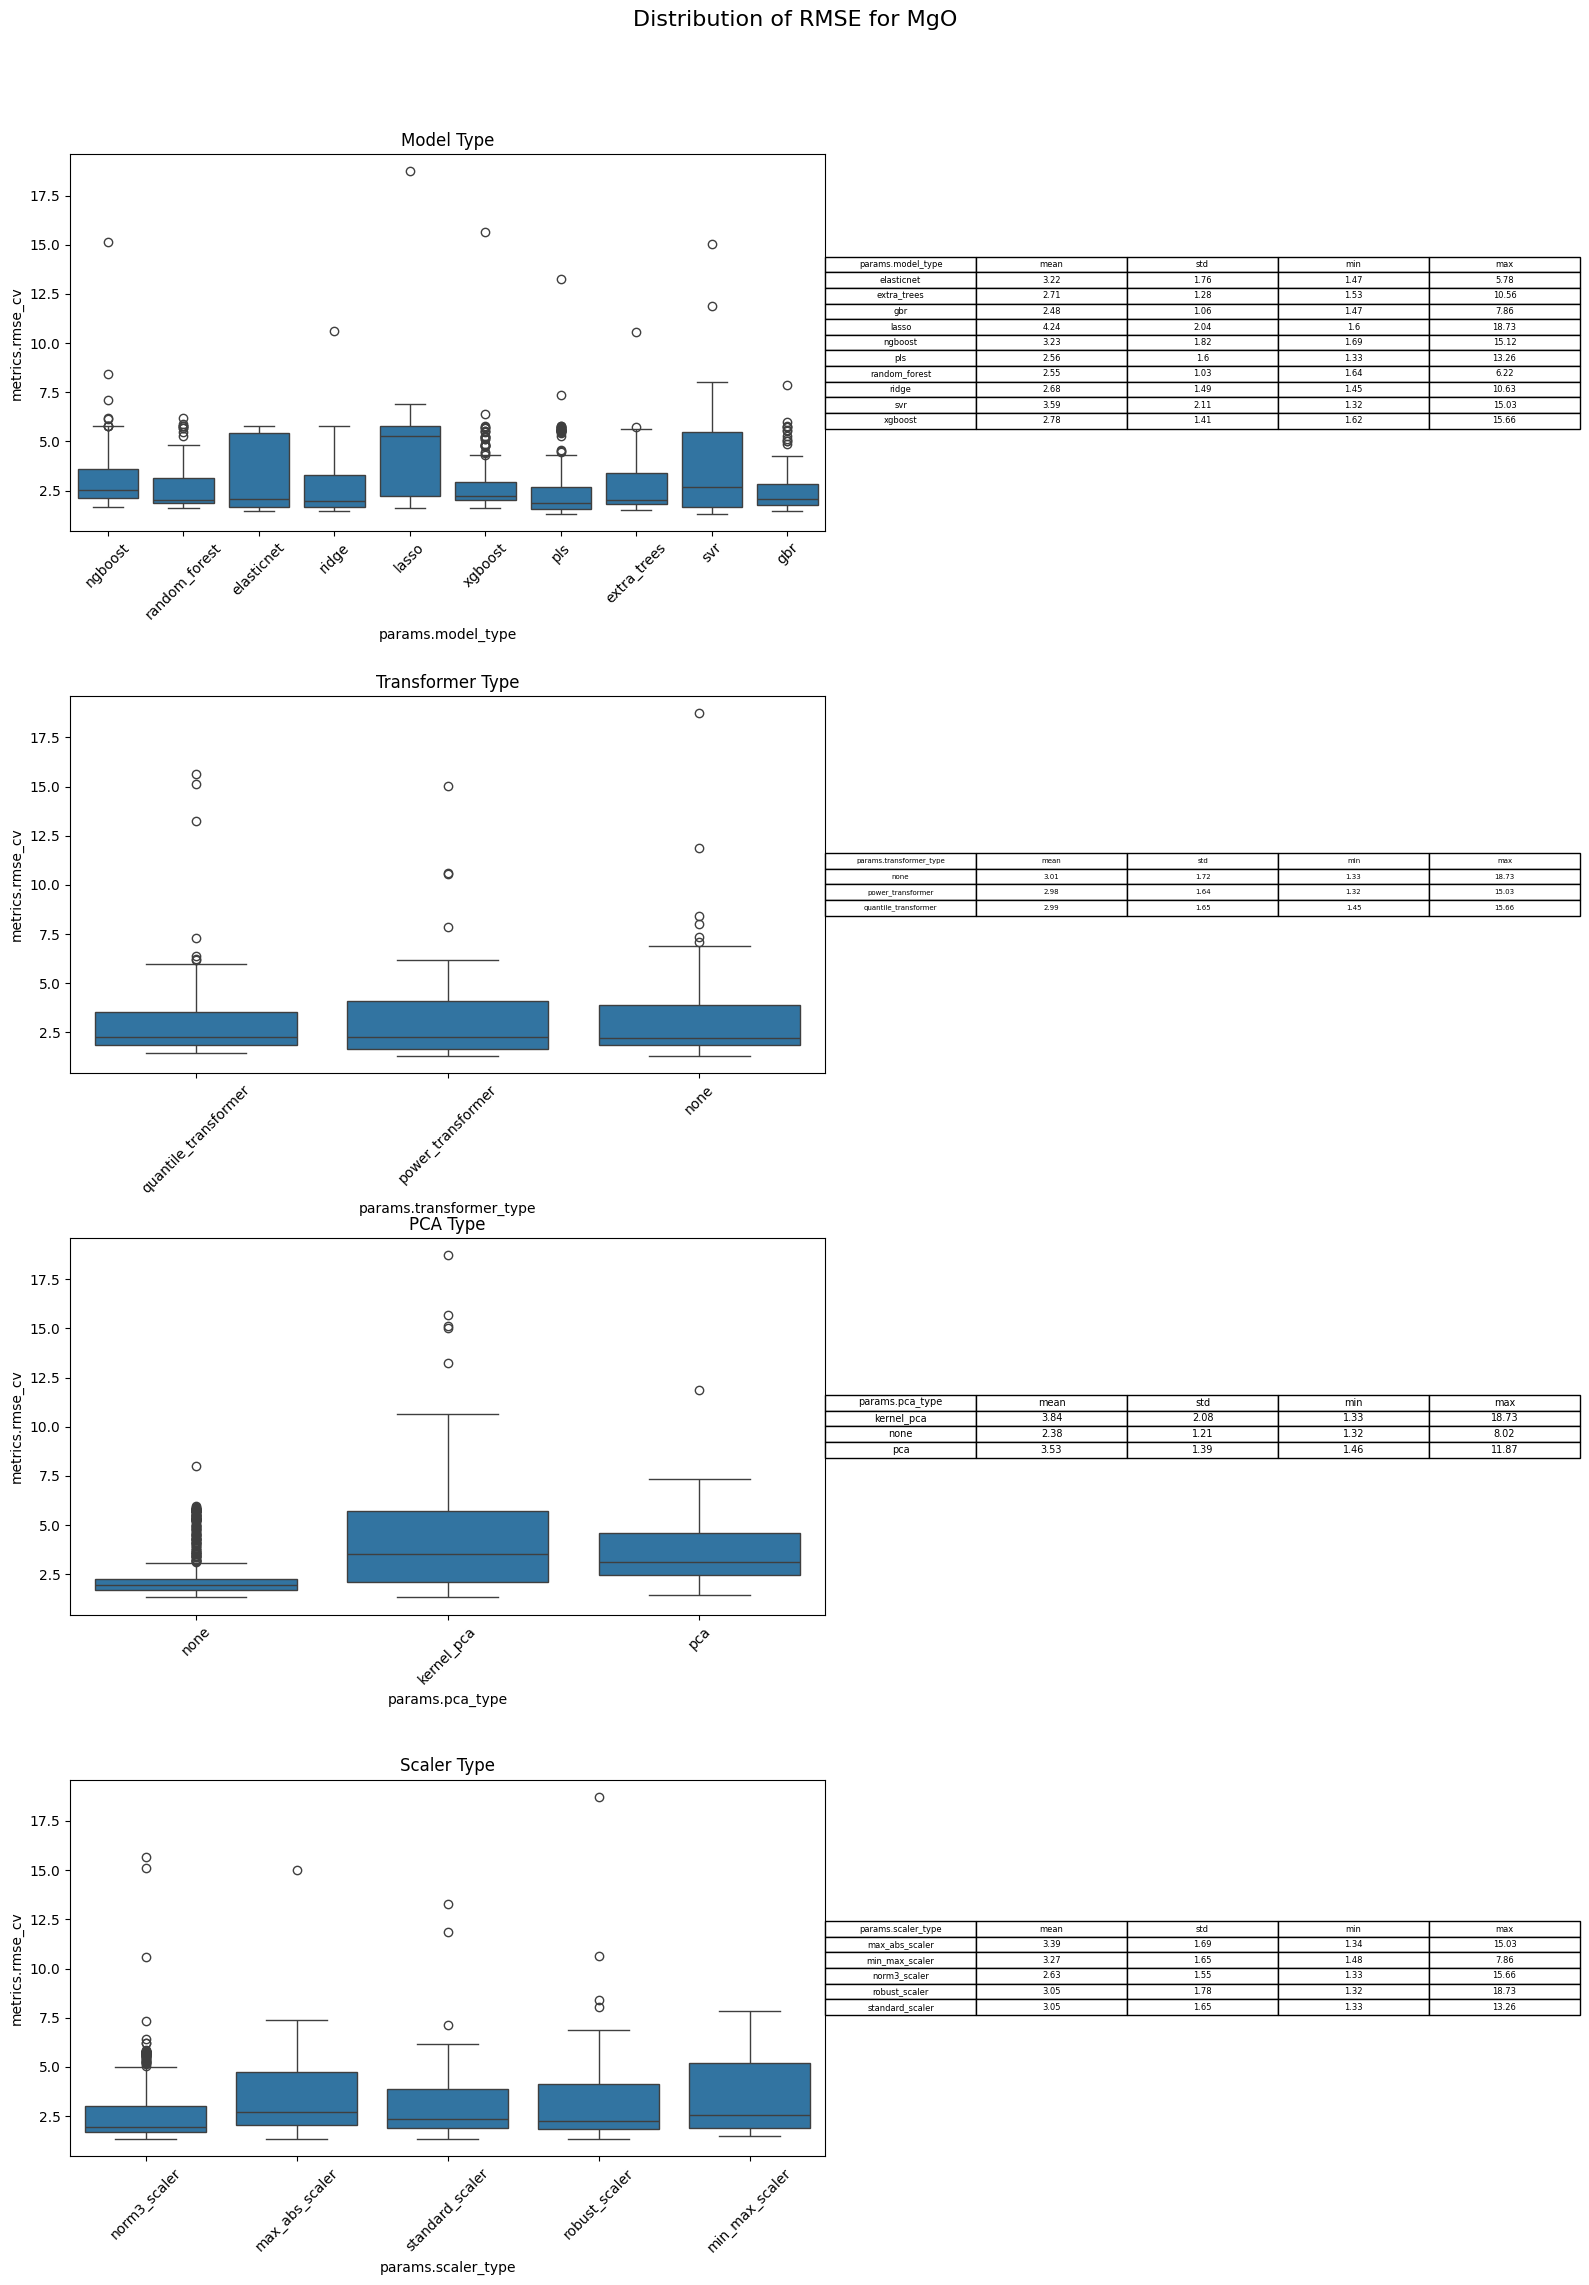

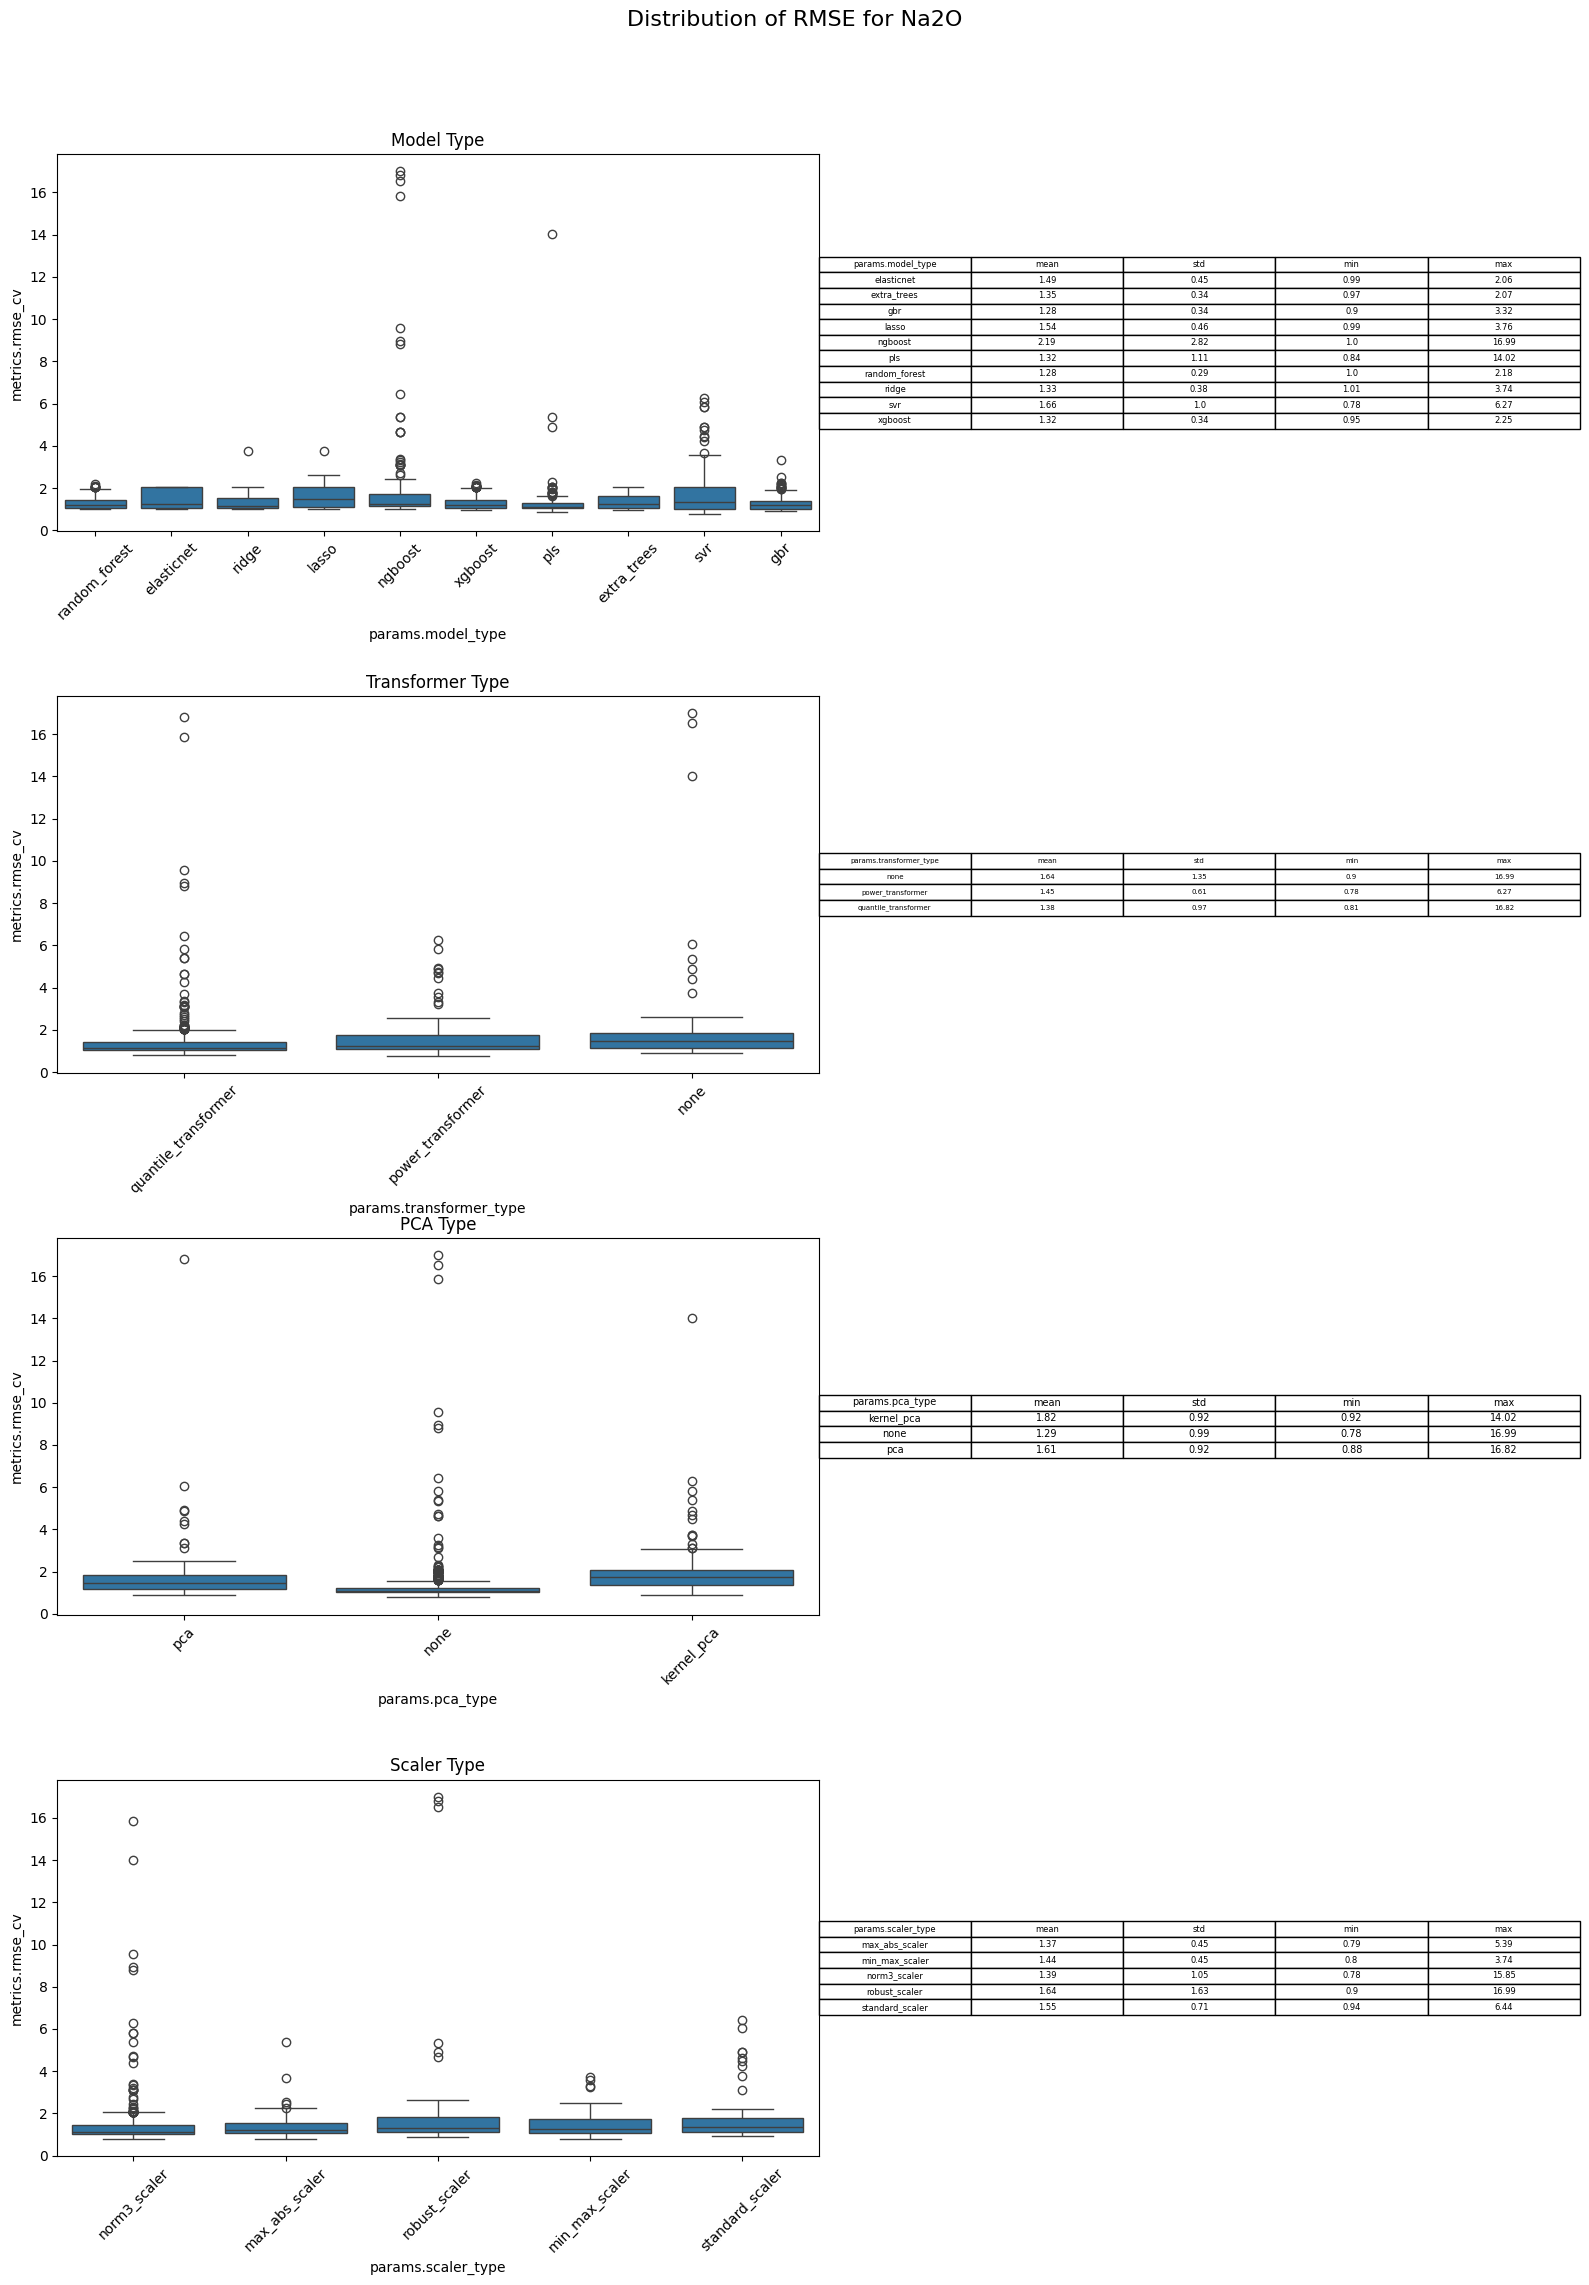

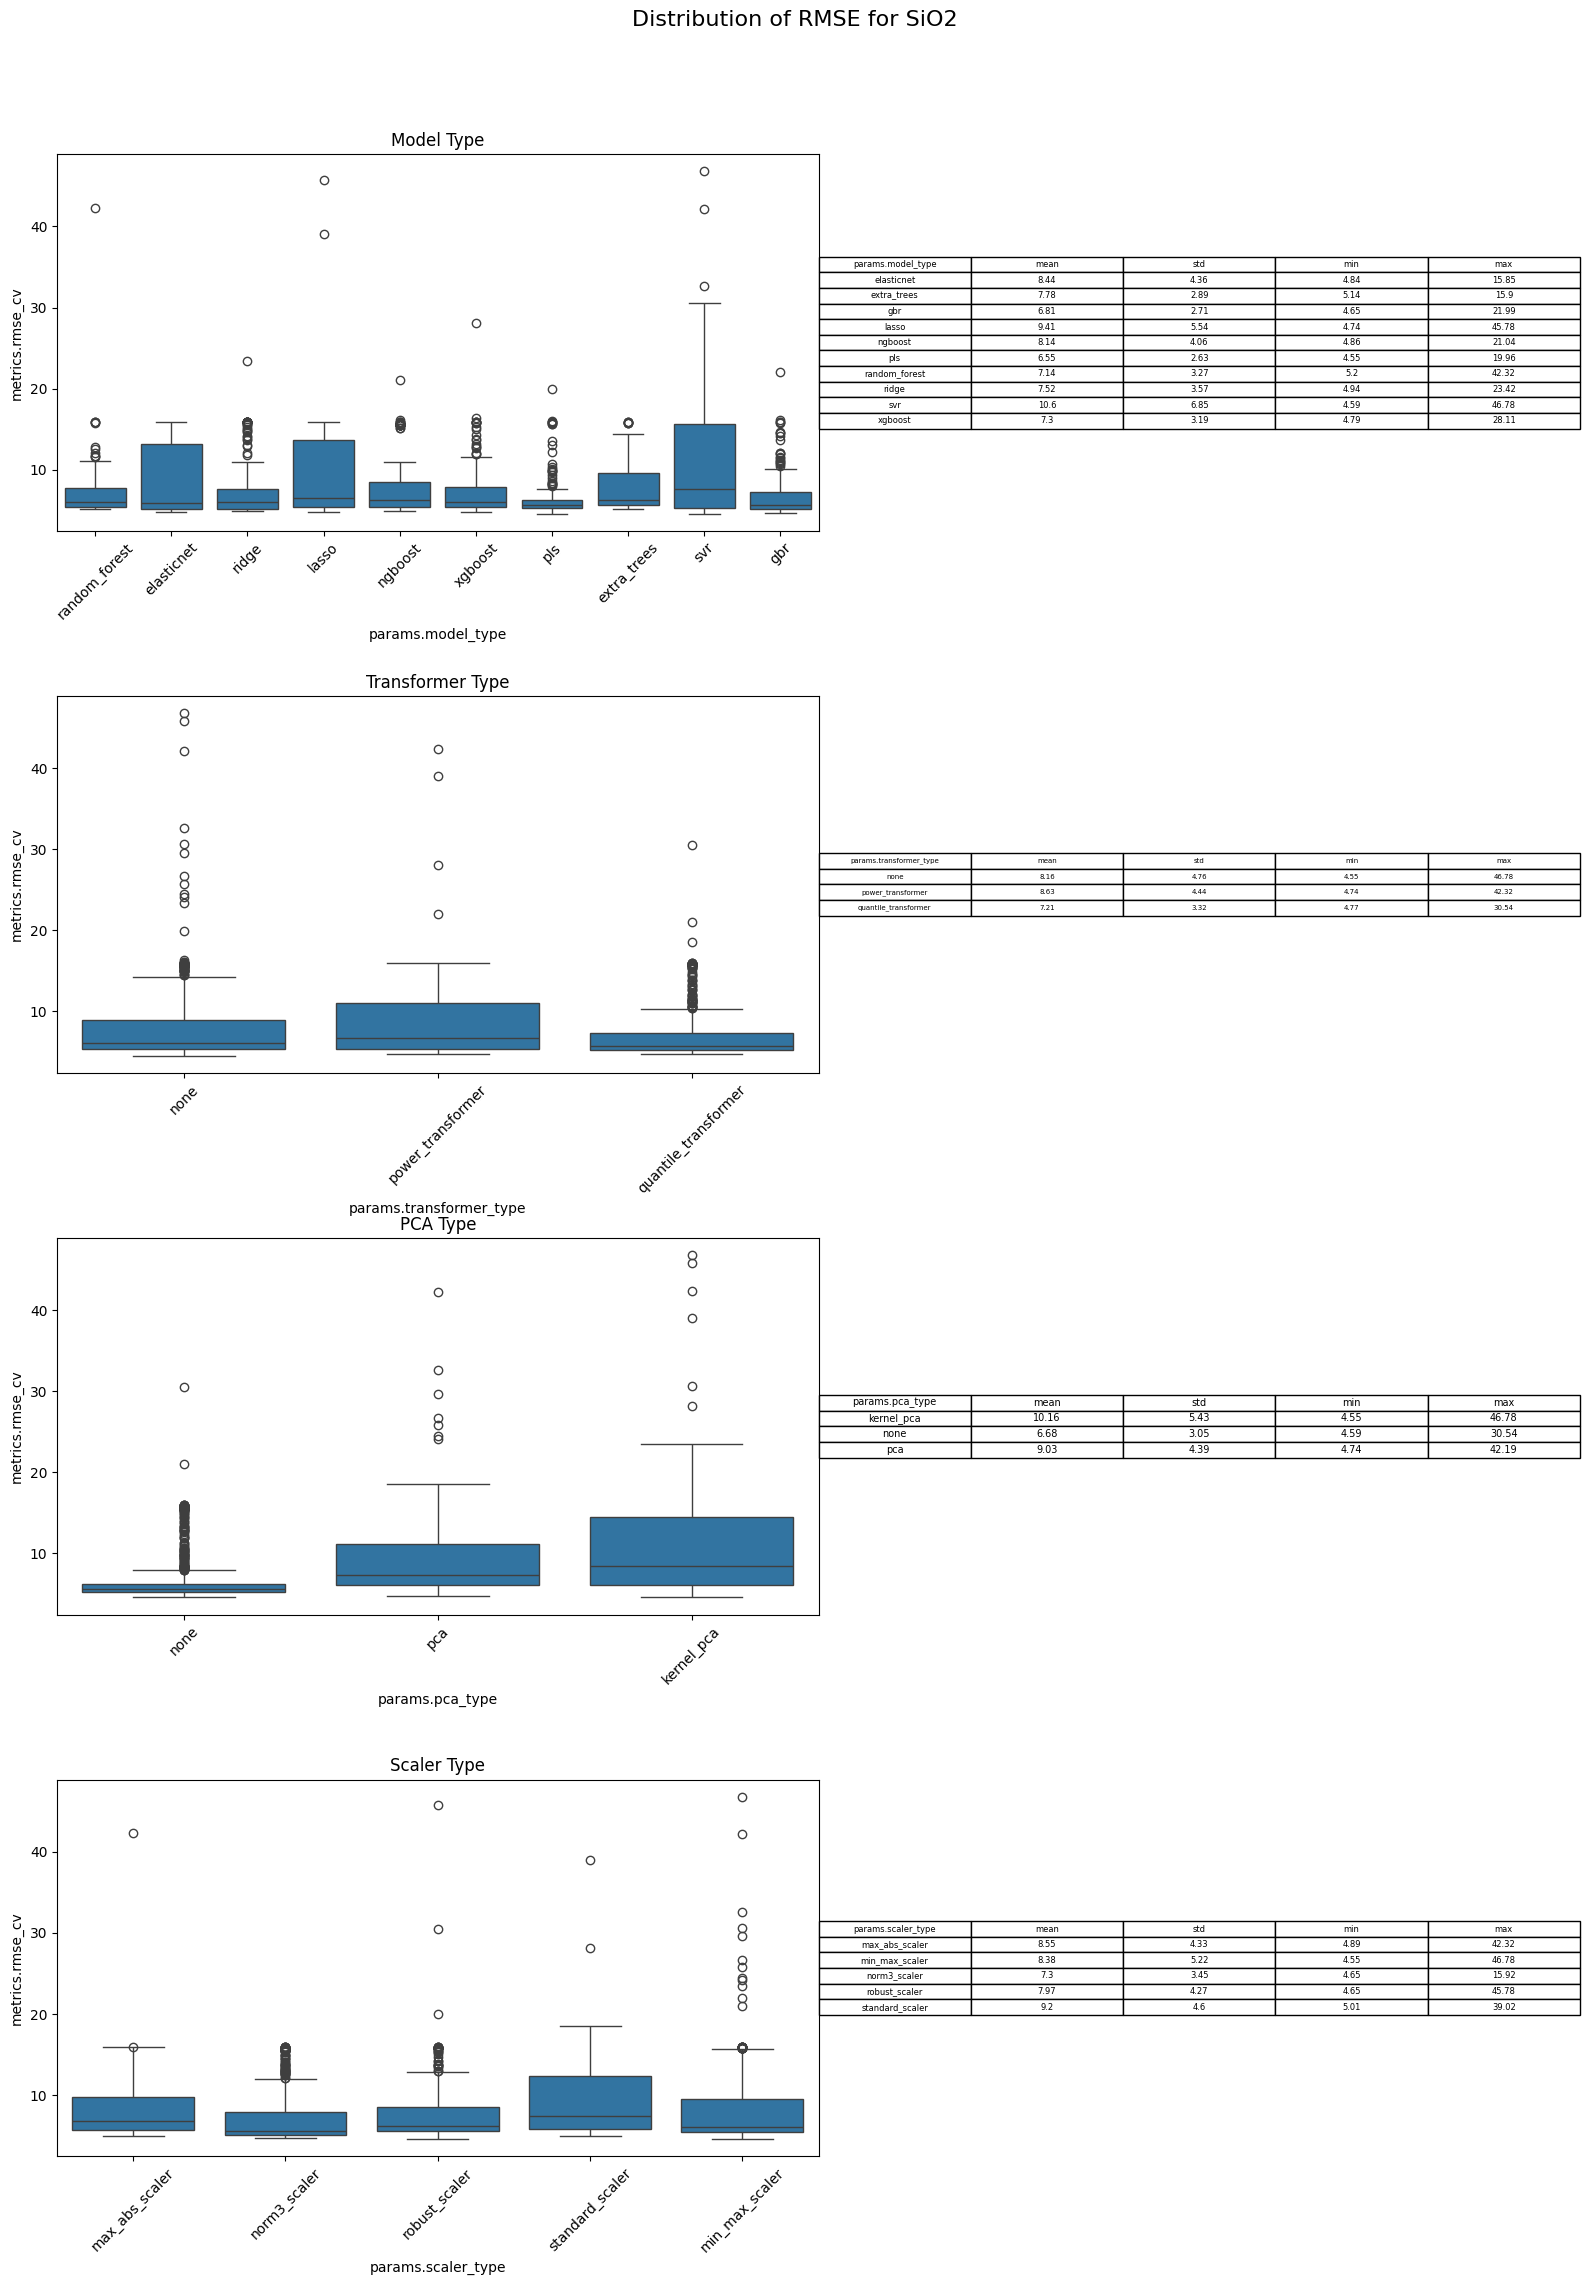

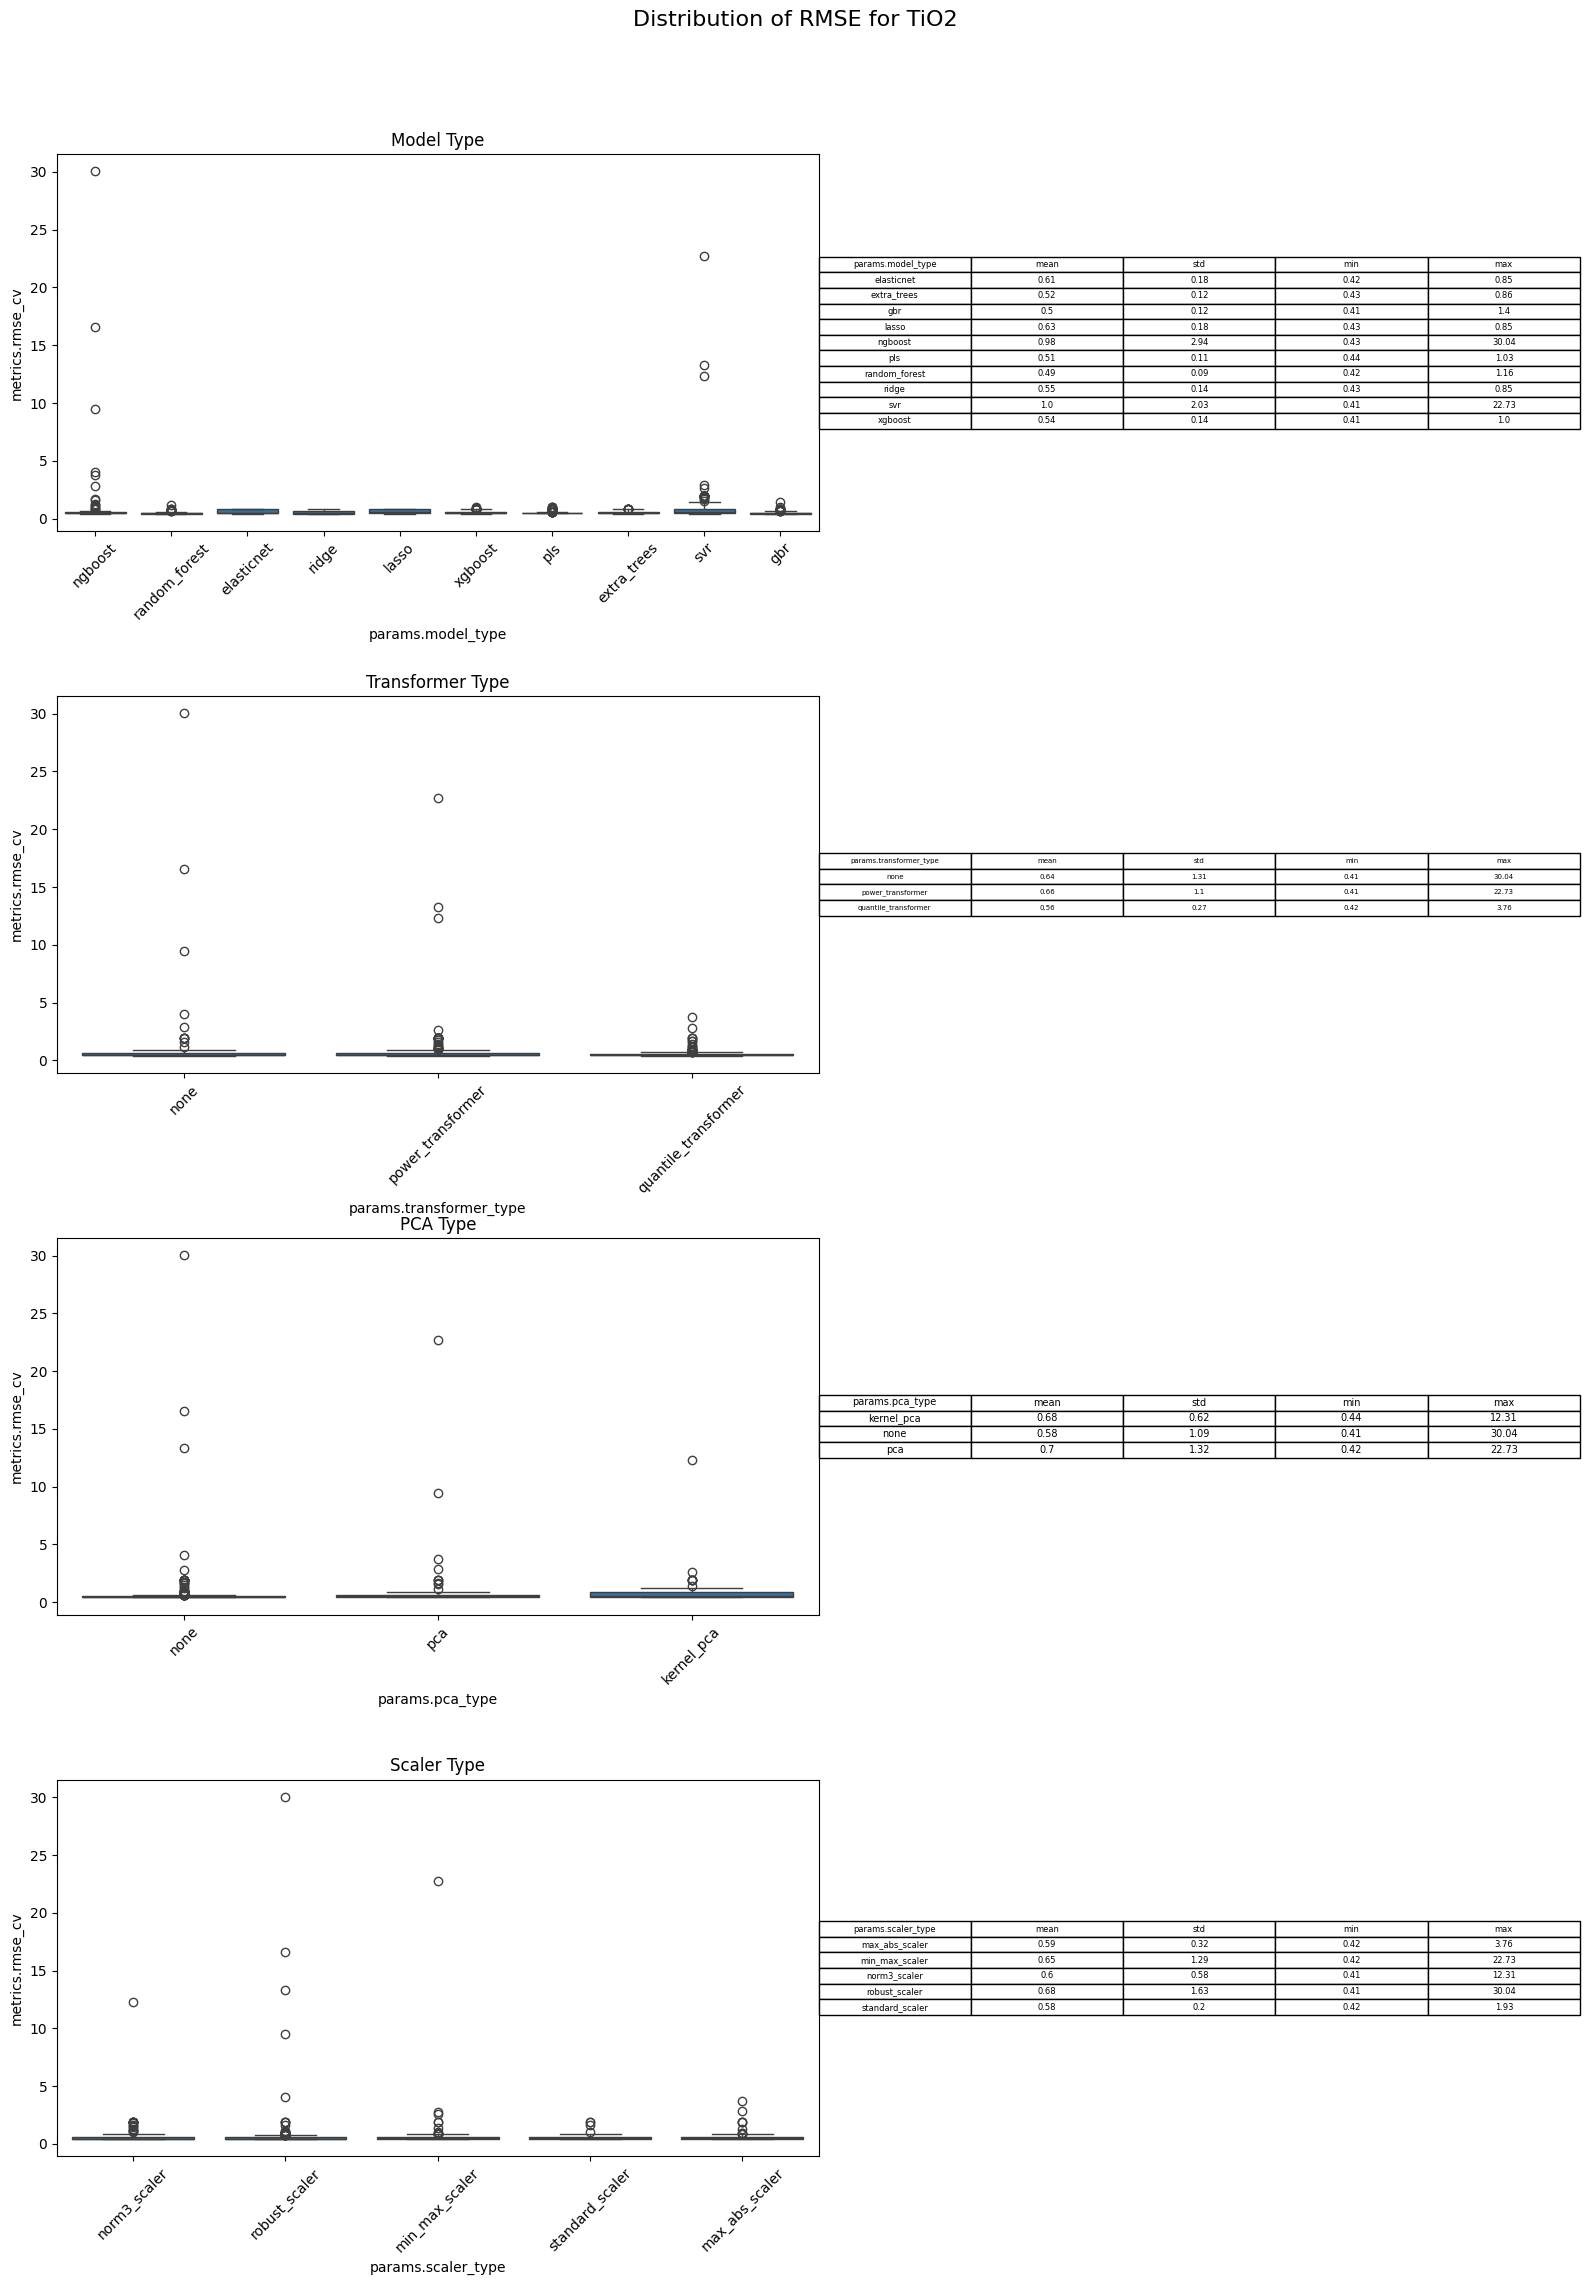

In [7]:
# Function to create box plots for each params.oxide
def create_box_plots(df):
    grouped = df.groupby('params.oxide')
    
    for oxide, group in grouped:
        plt.figure(figsize=(16, 24))  # Increased width from 16 to 24
        plt.suptitle(f'Distribution of RMSE for {oxide}', fontsize=16)

        # Box plot for params.model_type
        plt.subplot(4, 2, 1)
        sns.boxplot(x='params.model_type', y='metrics.rmse_cv', data=group)
        plt.title('Model Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 2)
        plt.axis('off')
        model_type_stats = group.groupby('params.model_type')['metrics.rmse_cv'].describe().reset_index()[['params.model_type', 'mean', 'std', 'min', 'max']]
        model_type_stats = model_type_stats.round(2)
        plt.table(cellText=model_type_stats.values, colLabels=model_type_stats.columns, cellLoc='center', loc='center')
        
        # Box plot for params.transformer_type
        plt.subplot(4, 2, 3)
        sns.boxplot(x='params.transformer_type', y='metrics.rmse_cv', data=group)
        plt.title('Transformer Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 4)
        plt.axis('off')
        transformer_type_stats = group.groupby('params.transformer_type')['metrics.rmse_cv'].describe().reset_index()[['params.transformer_type', 'mean', 'std', 'min', 'max']]
        transformer_type_stats = transformer_type_stats.round(2)
        plt.table(cellText=transformer_type_stats.values, colLabels=transformer_type_stats.columns, cellLoc='center', loc='center')

        # Box plot for params.pca_type
        plt.subplot(4, 2, 5)
        sns.boxplot(x='params.pca_type', y='metrics.rmse_cv', data=group)
        plt.title('PCA Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 6)
        plt.axis('off')
        pca_type_stats = group.groupby('params.pca_type')['metrics.rmse_cv'].describe().reset_index()[['params.pca_type', 'mean', 'std', 'min', 'max']]
        pca_type_stats = pca_type_stats.round(2)
        plt.table(cellText=pca_type_stats.values, colLabels=pca_type_stats.columns, cellLoc='center', loc='center')

        # Box plot for params.scaler_type
        plt.subplot(4, 2, 7)
        sns.boxplot(x='params.scaler_type', y='metrics.rmse_cv', data=group)
        plt.title('Scaler Type')
        plt.xticks(rotation=45)
        
        plt.subplot(4, 2, 8)
        plt.axis('off')
        scaler_type_stats = group.groupby('params.scaler_type')['metrics.rmse_cv'].describe().reset_index()[['params.scaler_type', 'mean', 'std', 'min', 'max']]
        scaler_type_stats = scaler_type_stats.round(2)
        plt.table(cellText=scaler_type_stats.values, colLabels=scaler_type_stats.columns, cellLoc='center', loc='center')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=0, h_pad=0)
        plt.show()

# Create box plots
create_box_plots(runs_filtered)

In [8]:
import pandas as pd
import scipy.stats as stats

# Function to perform Kruskal-Wallis H test
def analyze_correlations(df):
    results = []
    
    # Group by params.oxide
    grouped = df.groupby('params.oxide')
    
    for oxide, group in grouped:
        kw_results = {}
        for param in ['params.model_type', 'params.transformer_type', 'params.pca_type', 'params.scaler_type']:
            groups = [group['metrics.rmse_cv'][group[param] == level].values for level in group[param].unique()]
            if len(groups) > 1:  # Kruskal-Wallis test requires at least 2 groups
                stat, p_value = stats.kruskal(*groups)
                kw_results[param] = p_value
        
        # Identify the configuration with the lowest p-value
        best_param = min(kw_results, key=kw_results.get)
        results.append({
            'oxide': oxide,
            'best_param': best_param,
            'p_value': kw_results[best_param]
        })
    
    return pd.DataFrame(results)

# Load your data into df
# df = pd.read_csv('your_dataset.csv')

# Run the analysis
results_df = analyze_correlations(runs_filtered)


In [9]:
results_df

oxide       best_param        p_value
0  Al2O3  params.pca_type  6.341297e-122
1    CaO  params.pca_type  4.241883e-156
2   FeOT  params.pca_type  8.601464e-118
3    K2O  params.pca_type  1.430096e-143
4    MgO  params.pca_type   1.329345e-84
5   Na2O  params.pca_type  2.142521e-126
6   SiO2  params.pca_type   1.462530e-82
7   TiO2  params.pca_type   5.551974e-92

In [10]:
out = runs.groupby(['params.transformer_type', 'params.model_type', 'params.oxide']).size().reset_index(name='count')
pivot_table = out.pivot(index='params.oxide', columns=['params.transformer_type', 'params.model_type'], values='count')

# Add a total count for each transformer_type and oxide
out_total = runs.groupby(['params.transformer_type', 'params.oxide']).size().reset_index(name='total_count')
for transformer_type in out['params.transformer_type'].unique():
    pivot_table[(transformer_type, 'total_count')] = out_total[out_total['params.transformer_type'] == transformer_type].set_index('params.oxide')['total_count']

pivot_table

params.transformer_type       none                                     \
params.model_type       elasticnet extra_trees gbr lasso ngboost  pls   
params.oxide                                                            
Al2O3                           44          56  36    39      55   40   
CaO                             43         112  84    38     125   41   
FeOT                            43         117  44    51     120   41   
K2O                             44          39  55    33      36  128   
MgO                             43          46  82   106      70  126   
Na2O                            40          38  60    38      70   38   
SiO2                            58         103  83    40      44  127   
TiO2                           129          79  50    40     124   40   

params.transformer_type                                   ...  \
params.model_type       random_forest ridge  svr xgboost  ...   
params.oxide                                              ...   
Al2O3                              56    41   37      38  ...   
CaO                               120    40   33      37  ...   
FeOT                               41    40   37      99  ...   
K2O                                54    39   36      40  ...   
MgO                                52    41   37     107  ...   
Na2O                               42    40   38      37  ...   
SiO2                              101    37  129      38  ...   
TiO2                               44   128   37     107  ...   

params.transformer_type quantile_transformer                                   \
params.model_type                      lasso ngboost  pls random_forest ridge   
params.oxide                                                                    
Al2O3                                    128      38  126            37   123   
CaO                                       50      38  122            38   117   
FeOT                                     109      38   41           118   124   
K2O                                      100     118   36            38    36   
MgO                                       61      23   39           109    37   
Na2O                                      51      94  110           119   125   
SiO2                                      41      45   38            58    94   
TiO2                                      52      35   38           111    37   

params.transformer_type                     none power_transformer  \
params.model_type        svr xgboost total_count       total_count   
params.oxide                                                         
Al2O3                    123      53         442               649   
CaO                      106      38         673               595   
FeOT                     122      58         633               644   
K2O                      122      41         504               822   
MgO                       38      40         710               697   
Na2O                      39     122         441               583   
SiO2                      34     123         760               566   
TiO2                      39      51         778               717   

params.transformer_type quantile_transformer  
params.model_type                total_count  
params.oxide                                  
Al2O3                                    909  
CaO                                      732  
FeOT                                     723  
K2O                                      674  
MgO                                      510  
Na2O                                     976  
SiO2                                     674  
TiO2                                     505  

[8 rows x 33 columns]

In [11]:
# Define a threshold to filter out the extremely high RMSE values as outliers
threshold = 15

# Filter out rows with NaN values in 'params.transformer_type' and 'params.model_type'
filtered_data = runs.dropna(subset=['params.transformer_type', 'params.model_type'])

# Filter the data to remove outliers
filtered_data = filtered_data[filtered_data['metrics.rmse_cv'] < threshold]

# Calculate the mean RMSE for each combination of transformer type, model type, and oxide using 'metrics.rmse_cv'
mean_rmse_cv = filtered_data.groupby(['params.transformer_type', 'params.model_type', 'params.oxide'])['metrics.rmse_cv'].mean().reset_index()

# Calculate the overall mean RMSE for each combination of transformer type and model type using 'metrics.rmse_cv'
overall_mean_rmse_cv = filtered_data.groupby(['params.transformer_type', 'params.model_type'])['metrics.rmse_cv'].mean().reset_index()

mean_rmse_cv


params.transformer_type params.model_type params.oxide  metrics.rmse_cv
0                      none        elasticnet        Al2O3         5.461631
1                      none        elasticnet          CaO         5.455882
2                      none        elasticnet         FeOT         5.458367
3                      none        elasticnet          K2O         1.523440
4                      none        elasticnet          MgO         4.004144
..                      ...               ...          ...              ...
235    quantile_transformer           xgboost          K2O         1.108091
236    quantile_transformer           xgboost          MgO         2.961538
237    quantile_transformer           xgboost         Na2O         1.284493
238    quantile_transformer           xgboost         SiO2         6.641999
239    quantile_transformer           xgboost         TiO2         0.526246

[240 rows x 4 columns]

In [12]:
overall_mean_rmse_cv

params.transformer_type params.model_type  metrics.rmse_cv
0                     none        elasticnet         3.279757
1                     none       extra_trees         3.332615
2                     none               gbr         2.739534
3                     none             lasso         3.933685
4                     none           ngboost         2.748047
5                     none               pls         2.764185
6                     none     random_forest         2.955976
7                     none             ridge         2.861413
8                     none               svr         4.419211
9                     none           xgboost         2.564033
10       power_transformer        elasticnet         2.758652
11       power_transformer       extra_trees         2.707751
12       power_transformer               gbr         2.819086
13       power_transformer             lasso         2.998364
14       power_transformer           ngboost         3.569996
15       power_transformer               pls         2.299246
16       power_transformer     random_forest         2.645808
17       power_transformer             ridge         2.687279
18       power_transformer               svr         2.687348
19       power_transformer           xgboost         2.500394
20    quantile_transformer        elasticnet         3.239315
21    quantile_transformer       extra_trees         2.734293
22    quantile_transformer               gbr         2.407331
23    quantile_transformer             lasso         3.110400
24    quantile_transformer           ngboost         2.921342
25    quantile_transformer               pls         2.199902
26    quantile_transformer     random_forest         2.463116
27    quantile_transformer             ridge         2.763347
28    quantile_transformer               svr         3.353785
29    quantile_transformer           xgboost         3.168671

In [13]:
overall_mean_rmse_cv.groupby(['params.transformer_type'])['metrics.rmse_cv'].mean().reset_index()

params.transformer_type  metrics.rmse_cv
0                    none         3.159845
1       power_transformer         2.767392
2    quantile_transformer         2.836150

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and pivot the data
teste = mean_rmse_cv.groupby(['params.transformer_type', 'params.oxide'])['metrics.rmse_cv'].mean().reset_index()
pivot_table = teste.pivot(index='params.oxide', columns='params.transformer_type', values='metrics.rmse_cv')
pivot_table

params.transformer_type      none  power_transformer  quantile_transformer
params.oxide                                                              
Al2O3                    4.191592           3.782426              3.314876
CaO                      3.376023           2.769860              3.074937
FeOT                     4.423880           4.308292              4.155834
K2O                      1.201299           1.001218              1.080698
MgO                      3.093727           3.104998              3.100466
Na2O                     1.597966           1.442915              1.406117
SiO2                     6.961690           7.308133              6.518524
TiO2                     0.581660           0.593364              0.614327

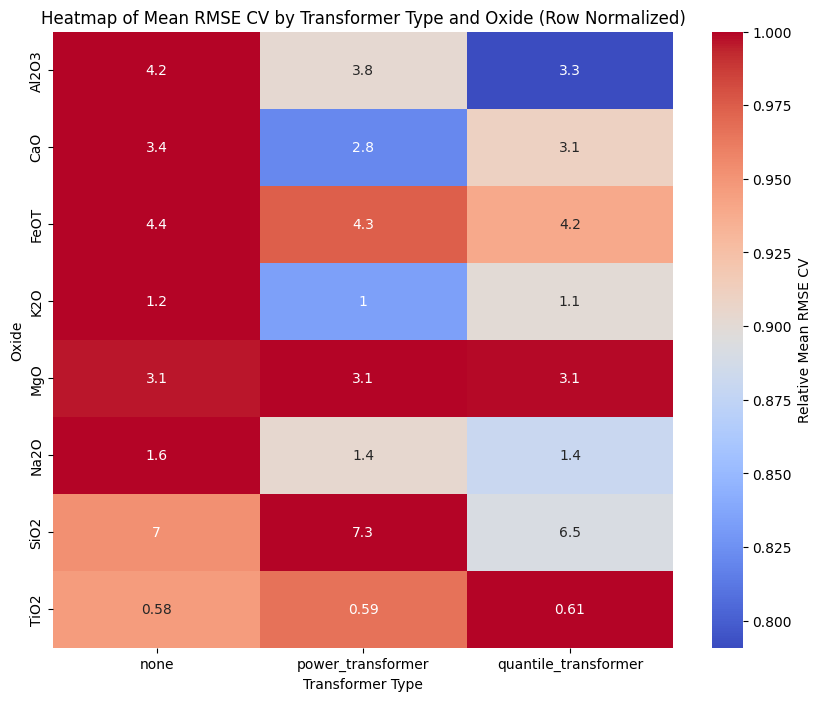

In [15]:
# Normalize the data by row
pivot_table_normalized = pivot_table.div(pivot_table.max(axis=1), axis=0)

# Plot the heatmap with a more visually comfortable color palette
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table_normalized, annot=pivot_table, cmap='coolwarm', cbar_kws={'label': 'Relative Mean RMSE CV'})
plt.title('Heatmap of Mean RMSE CV by Transformer Type and Oxide (Row Normalized)')
plt.xlabel('Transformer Type')
plt.ylabel('Oxide')
plt.show()


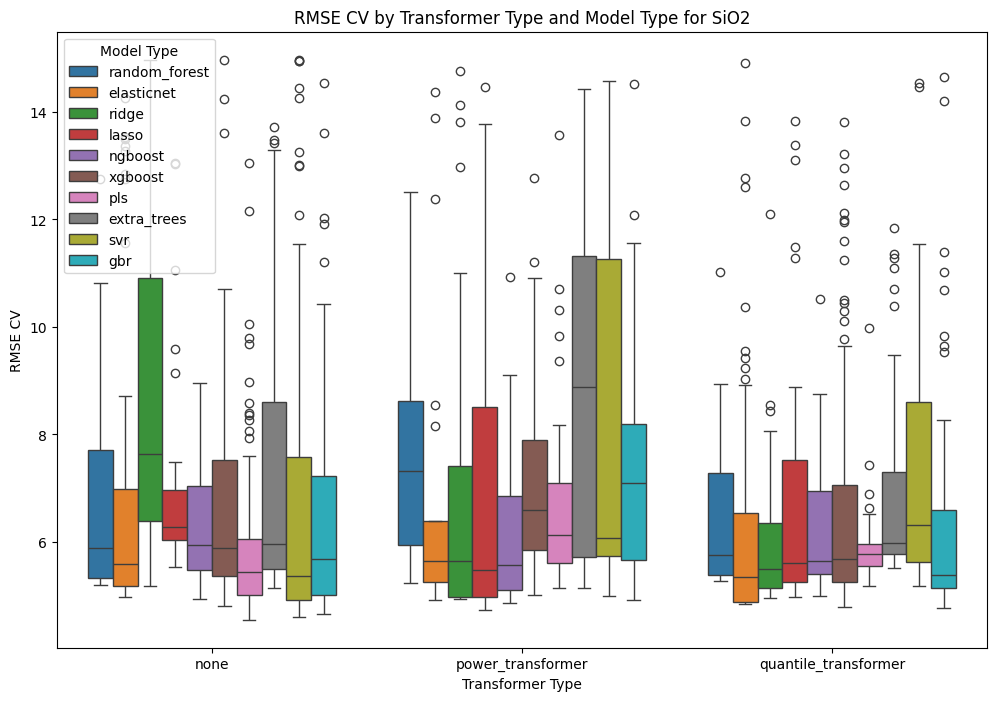

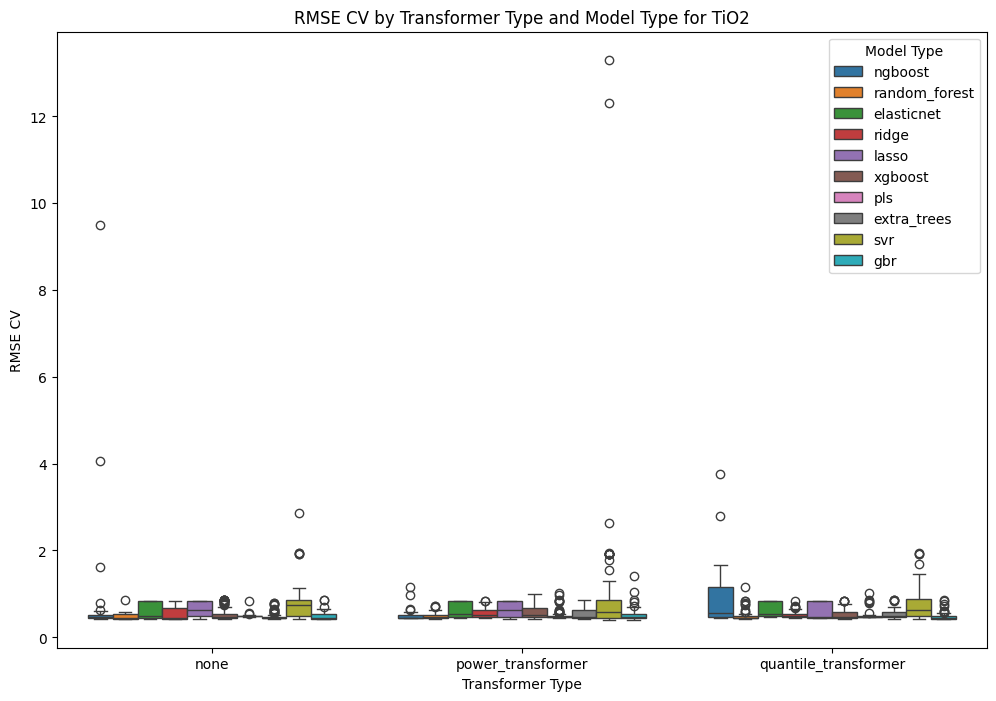

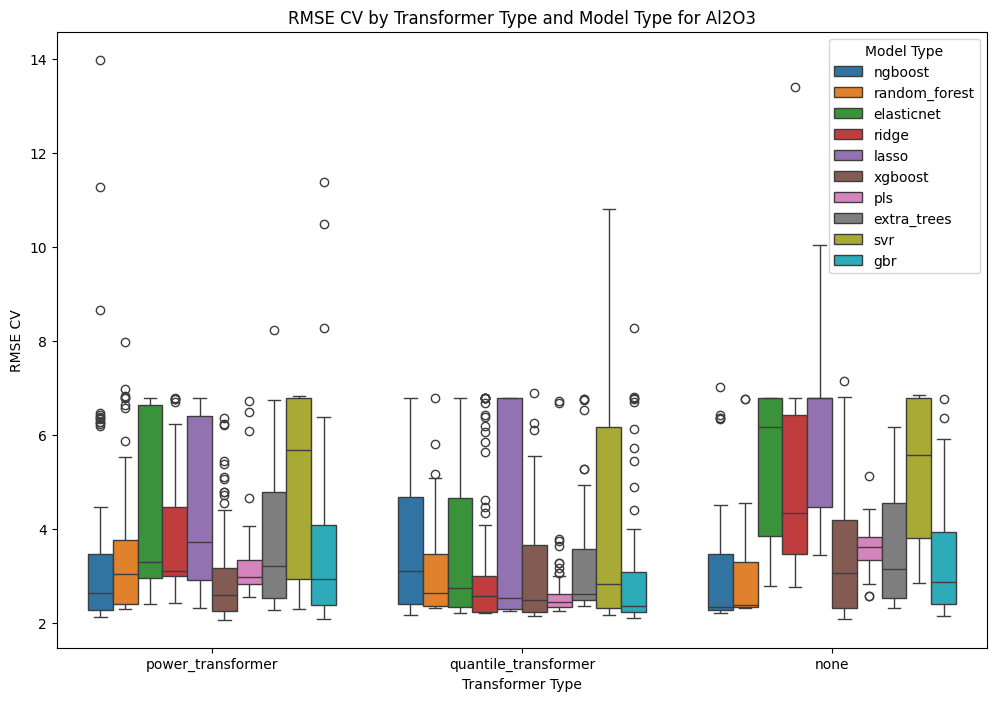

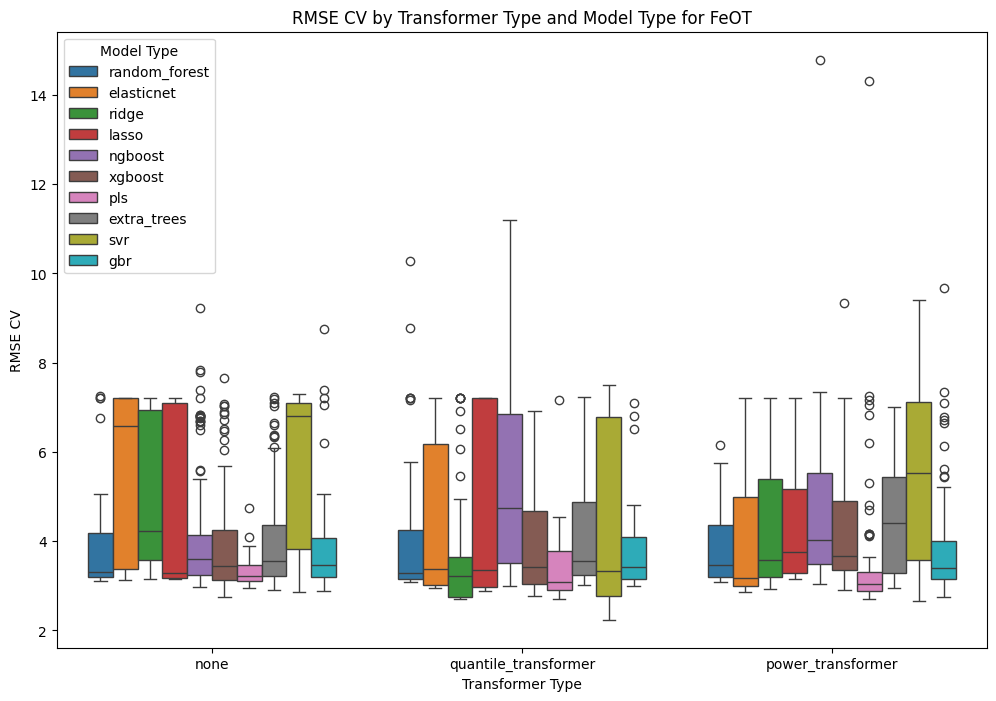

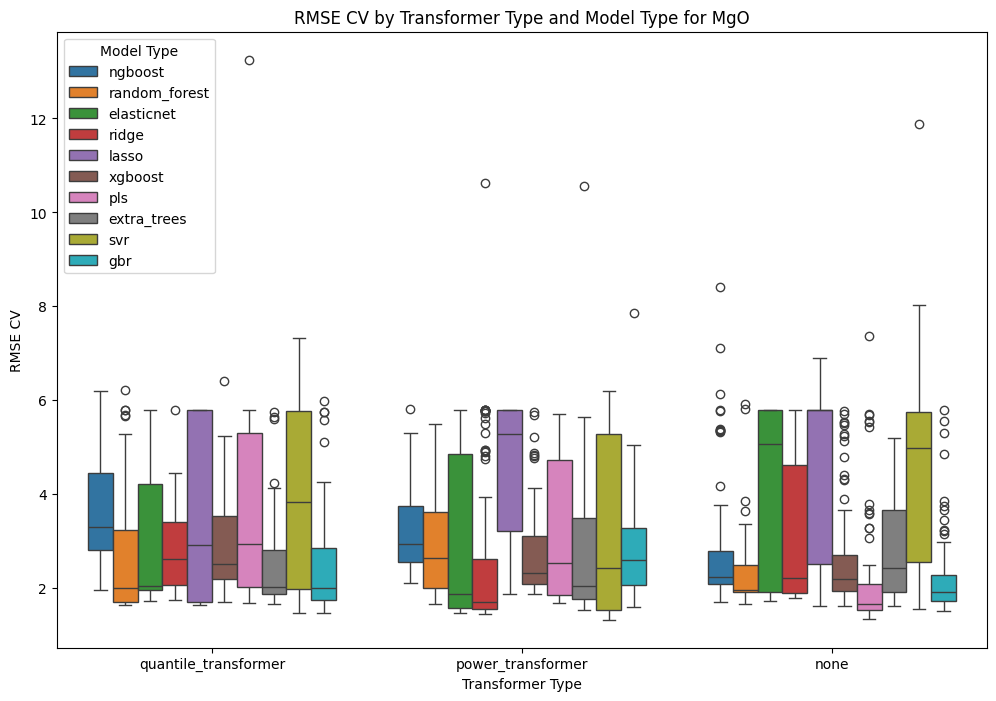

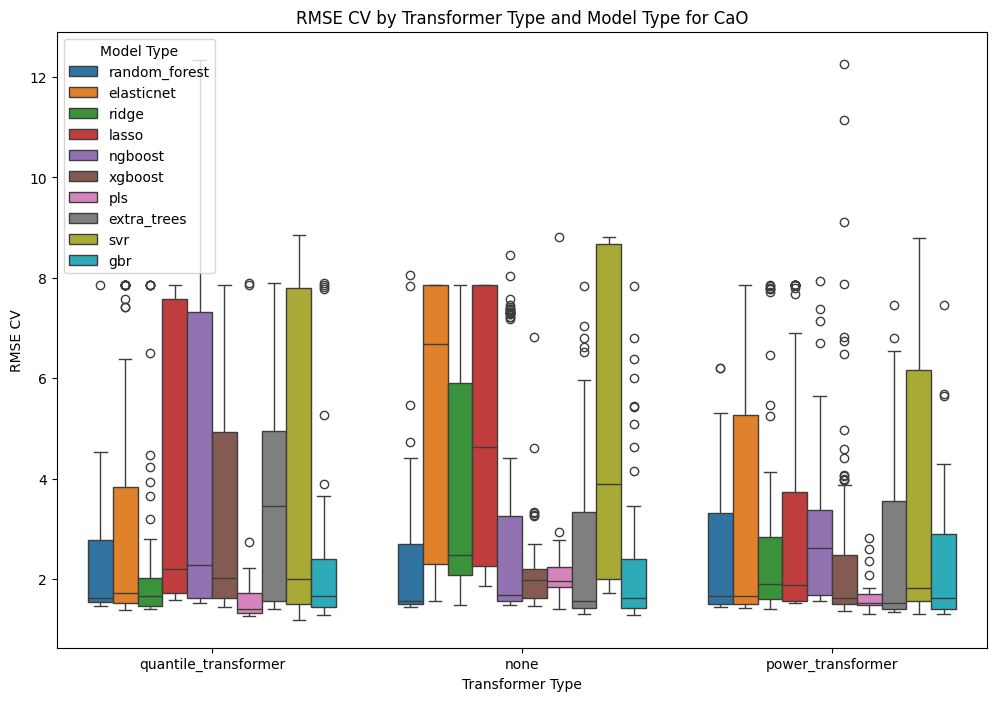

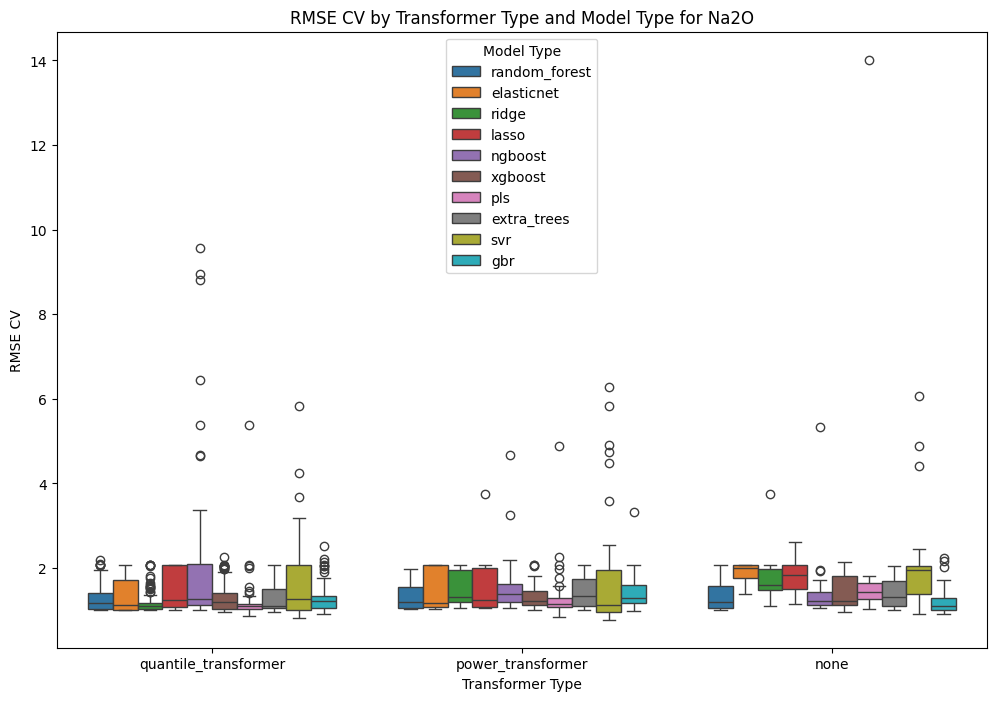

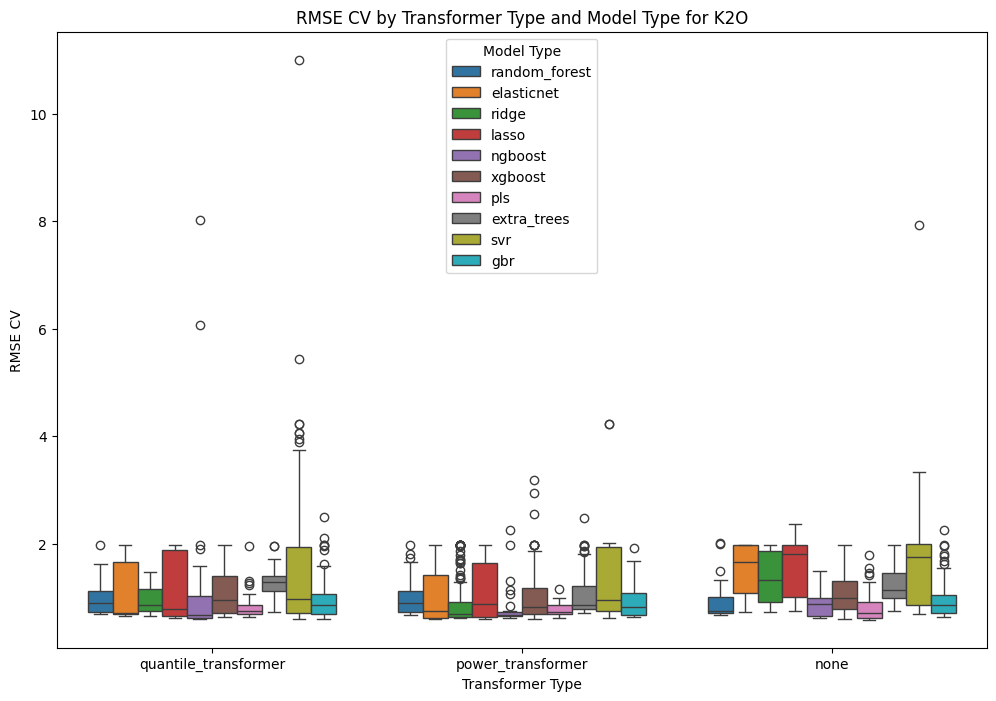

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for overall RMSE CV by transformer type and model type for each oxide
oxides = filtered_data['params.oxide'].unique()

for oxide in oxides:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='params.transformer_type', y='metrics.rmse_cv', hue='params.model_type', data=filtered_data[filtered_data['params.oxide'] == oxide])
    plt.title(f'RMSE CV by Transformer Type and Model Type for {oxide}')
    plt.xlabel('Transformer Type')
    plt.ylabel('RMSE CV')
    plt.legend(title='Model Type')
    plt.show()


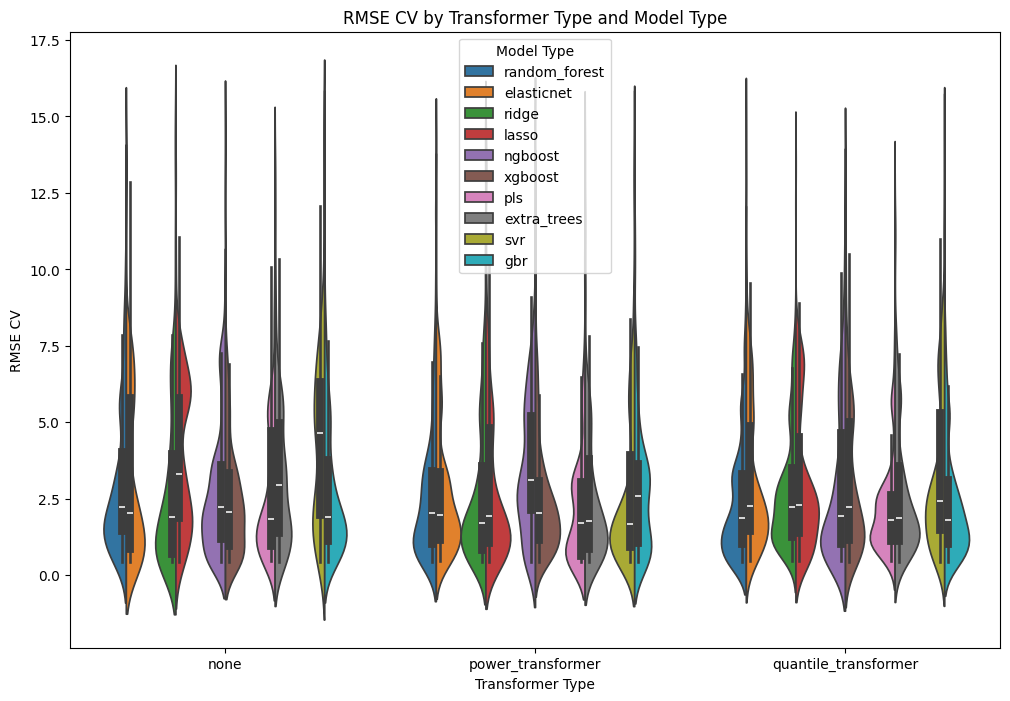

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.figure(figsize=(12, 8))

# Create a violin plot for overall RMSE CV by transformer type and model type
sns.violinplot(x='params.transformer_type', y='metrics.rmse_cv', hue='params.model_type', data=filtered_data, split=True)

# Title and labels
plt.title('RMSE CV by Transformer Type and Model Type')
plt.xlabel('Transformer Type')
plt.ylabel('RMSE CV')

# Show the plot
plt.legend(title='Model Type')
plt.show()

